**What's different?**
1. More reasonable contextual outliers trimming.
2. More in-depth analysis on how to improve the model, explaining which steps really affect the model.

Comparable final MAPE but significant increase of data with APE more than 20%.

# Library

In [34]:
#Basic data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Statistics
from scipy.stats import normaltest, norm
from scipy import stats

#Pre-Processing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from sklearn.pipeline import Pipeline

#Algorithm models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


#Metric evaluation
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error

In [35]:
pd.set_option('display.max_columns', None)

# Data

In [36]:
df=pd.read_csv('df_predict.csv',low_memory=False)
df.head()

,building_code_description,category_code_description,central_air,depth,exterior_condition,fireplaces,frontage,interior_condition,location,market_value,number_of_bathrooms,number_of_bedrooms,number_of_rooms,number_stories,other_building,parcel_number,parcel_shape,sale_date,sale_price,street_designation,topography,total_area,total_livable_area,unfinished,view_type,year_built,zip_code,zoning,new_zoning,sale_year,sale_year_group,parking_spaces,overall_condition,property_age
0,ROW W/GAR 3 STY MASONRY,Single Family,N,49.0,5.0,0,15.90,5.0,108 WHARTON ST,186800.0,2.0,4.0,7.0,3.0,N,11000600,E,1951-01-31,1.0,ST,F,779.0,1650.0,F,I,1920.0,19147,RSA5,Residential Single Family,1951.0,1955-1951,1,5.0,100.0
1,ROW 3 STY MASONRY,Single Family,Y,49.0,2.0,0,15.90,2.0,110 WHARTON ST,341600.0,1.0,3.0,4.0,3.0,N,11000700,E,2017-04-14,395000.0,ST,F,779.1,1203.0,F,I,1920.0,19147,RSA5,Residential Single Family,2017.0,2020-2016,0,2.0,100.0
2,ROW 3 STY MASONRY,Single Family,N,49.0,4.0,0,14.80,4.0,112 WHARTON ST,226200.0,1.0,4.0,5.0,2.0,N,11000800,E,1975-09-04,1.0,ST,F,725.2,1482.0,F,I,1920.0,19147,RSA5,Residential Single Family,1975.0,1975-1971,0,4.0,100.0
3,ROW 3 STY MASONRY,Single Family,Y,100.0,4.0,0,14.33,4.0,114 WHARTON ST,241500.0,2.0,4.0,8.0,2.0,N,11000900,E,2012-02-16,1.0,ST,F,1433.0,2049.0,F,I,1920.0,19147,RSA5,Residential Single Family,2012.0,2015-2011,0,4.0,100.0
4,ROW 3 STY MASONRY,Single Family,N,100.0,4.0,0,15.00,4.0,116 WHARTON ST,237000.0,2.0,4.0,6.0,3.0,N,11001000,E,2017-07-21,1.0,ST,F,1500.0,1155.0,F,I,1920.0,19147,RSA5,Residential Single Family,2017.0,2020-2016,0,4.0,100.0


In [37]:
df['zip_code']=df['zip_code'].apply(lambda x: str(x))

In [38]:
df_describe =[]

for i in df.columns:
    df_describe.append([
        i,
        df[i].dtypes,
        df[i].isna().sum(),
        round((((df[i].isna().sum())/(len(df)))*100),2),
        df[i].nunique(),
        df[i].unique()
    ])

## Data Description

In [39]:
desc=pd.DataFrame(df_describe, columns=['column','type','nan','nan%','nunique','unique'])
desc

,column,type,nan,nan%,nunique,unique
0,building_code_description,object,0,0.0,444,"[ROW W/GAR 3 STY MASONRY, ROW 3 STY MASONRY, R..."
1,category_code_description,object,0,0.0,6,"[Single Family, Multi Family, Commercial, Mixe..."
2,central_air,object,0,0.0,3,"[N, Y, 0]"
3,depth,float64,0,0.0,17825,"[49.0, 100.0, 90.0, 32.0, 60.0, 48.0, 45.46, 4..."
4,exterior_condition,float64,0,0.0,8,"[5.0, 2.0, 4.0, 3.0, 1.0, 6.0, 7.0, 0.0]"
5,fireplaces,object,0,0.0,5,"[0, 1, 2, 3, >3]"
6,frontage,float64,0,0.0,10866,"[15.9, 14.8, 14.33, 15.0, 29.17, 18.03, 18.05,..."
7,interior_condition,float64,0,0.0,8,"[5.0, 2.0, 4.0, 3.0, 1.0, 6.0, 7.0, 0.0]"
8,location,object,0,0.0,492389,"[108 WHARTON ST, 110 WHARTON ST, 112 WHARTON S..."
9,market_value,float64,0,0.0,14965,"[186800.0, 341600.0, 226200.0, 241500.0, 23700..."


# Feature Selection

Feature for modeling was selected mainly using domain knowledge with the support of detailed EDA in previous notebook. Feature selection was done with checking the meaning and the relevancy of every columns to the prediction target which is market value of the property. If the column didn't have any relationship with prediction target, either logically and/or by statistical test, we will not use it in modeling.

## Numerical Feature

In [40]:
numerical_feature = [feature for feature in df.columns if df[feature].dtypes != 'O'] #list comprehention for selecting non object data type in dataframe
numerical_feature.remove('sale_price')
numerical_feature.remove('market_value')
numerical_feature.remove('parcel_number')
print ('Count of numerical features:' , len(numerical_feature))

df[numerical_feature].head()

Count of numerical features: 14


,depth,exterior_condition,frontage,interior_condition,number_of_bathrooms,number_of_bedrooms,number_of_rooms,number_stories,total_area,total_livable_area,year_built,sale_year,overall_condition,property_age
0,49.0,5.0,15.90,5.0,2.0,4.0,7.0,3.0,779.0,1650.0,1920.0,1951.0,5.0,100.0
1,49.0,2.0,15.90,2.0,1.0,3.0,4.0,3.0,779.1,1203.0,1920.0,2017.0,2.0,100.0
2,49.0,4.0,14.80,4.0,1.0,4.0,5.0,2.0,725.2,1482.0,1920.0,1975.0,4.0,100.0
3,100.0,4.0,14.33,4.0,2.0,4.0,8.0,2.0,1433.0,2049.0,1920.0,2012.0,4.0,100.0
4,100.0,4.0,15.00,4.0,2.0,4.0,6.0,3.0,1500.0,1155.0,1920.0,2017.0,4.0,100.0


With the recommendation from detailed EDA from previous notebook, we will only use these numerical columns:
1. number_of_bedrooms
2. number_of_rooms
3. number_of_bathrooms
4. number_stories
5. overall_condition
6. property_age
7. sale_year
8. total_area
9. total_livable_area

Several columns were dropped:
1. exterior_condition and interior_condition, because already represented by overall_condition
2. depth and frontage, because already represented by total_area
3. year_built, because already represented by property_age
4. parcel_number, because we only include it in dataframe as unique identifier of properties

## Categorical Feature

In [41]:
categorical_feature = [feature for feature in df.columns if df[feature].dtypes == 'O'] #list comprehention for selecting non object data type in dataframe
print ('Number of categorical feature:' , len(categorical_feature))

df[categorical_feature].head()

Number of categorical feature: 17


,building_code_description,category_code_description,central_air,fireplaces,location,other_building,parcel_shape,sale_date,street_designation,topography,unfinished,view_type,zip_code,zoning,new_zoning,sale_year_group,parking_spaces
0,ROW W/GAR 3 STY MASONRY,Single Family,N,0,108 WHARTON ST,N,E,1951-01-31,ST,F,F,I,19147,RSA5,Residential Single Family,1955-1951,1
1,ROW 3 STY MASONRY,Single Family,Y,0,110 WHARTON ST,N,E,2017-04-14,ST,F,F,I,19147,RSA5,Residential Single Family,2020-2016,0
2,ROW 3 STY MASONRY,Single Family,N,0,112 WHARTON ST,N,E,1975-09-04,ST,F,F,I,19147,RSA5,Residential Single Family,1975-1971,0
3,ROW 3 STY MASONRY,Single Family,Y,0,114 WHARTON ST,N,E,2012-02-16,ST,F,F,I,19147,RSA5,Residential Single Family,2015-2011,0
4,ROW 3 STY MASONRY,Single Family,N,0,116 WHARTON ST,N,E,2017-07-21,ST,F,F,I,19147,RSA5,Residential Single Family,2020-2016,0


In [42]:
df[categorical_feature].describe(include=object).T

,count,unique,top,freq
building_code_description,495390,444,ROW 2 STY MASONRY,176534
category_code_description,495390,6,Single Family,427156
central_air,495390,3,0,233117
fireplaces,495390,5,0,481781
location,495390,492389,112 N 2ND ST,183
other_building,495390,2,N,494609
parcel_shape,495390,5,E,457366
sale_date,495390,22535,1943-01-01,375
street_designation,495390,23,ST,364770
topography,495390,7,F,461324


With the recommendation from detailed EDA from previous notebook, we will only use these categorical columns:
1. category_code_description
2. central_air
3. fireplaces
4. new_zoning
5. other_building
6. parcel_shape
7. parking_spaces
8. street_designation
9. topography
10. unfinished
11. view_type
12. zip_code 

Several columns were dropped:
1. building_code_description and location, because it represents the building type and the building location. One location or building_code_description can contain more than 1 property. Also, both columns containing too specific information that hypothetically will lead to overfitting in modeling. Zip code column can be used to generalize the location of the property.
2. sale_date and sale_year_group, because they already represented by sale_year column.
3. zoning, because we replace its values by create new_zoning columns.

## Final Feature Selection

In [167]:
df_predict = df[['market_value','number_of_bedrooms','number_of_rooms','number_of_bathrooms','number_stories',
    'overall_condition','property_age','sale_year','total_area','total_livable_area',
    'category_code_description','central_air','fireplaces','new_zoning','other_building',
    'parcel_shape','parking_spaces','street_designation','topography','unfinished','view_type','zip_code','building_code_description']].copy()

# Contextual Outlier Analysis

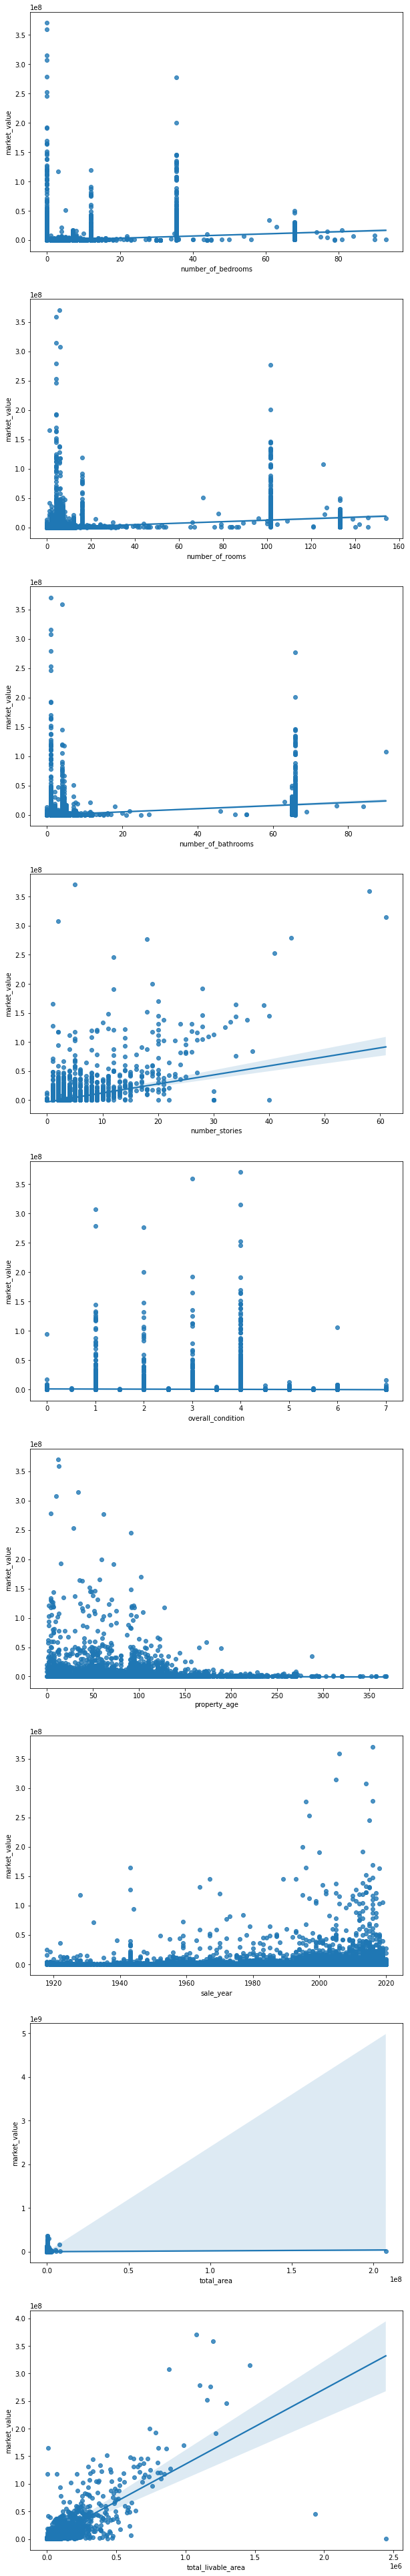

In [46]:
fig, ax = plt.subplots(9,1, figsize=(10,70))
for variable, subplot in zip(['number_of_bedrooms','number_of_rooms','number_of_bathrooms','number_stories',
                              'overall_condition','property_age','sale_year','total_area','total_livable_area'], ax.flatten()):
    sns.regplot(data=df_predict, y='market_value', x=variable, ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(0)

From scatterplot above, we can drop several contextual outliers:

## Total Livable Area

We need to drop data with high total livable area but low market value.

In [168]:
index=df_predict[df_predict['total_livable_area']>1.5*1e6].index
df_predict.drop(index, inplace=True)

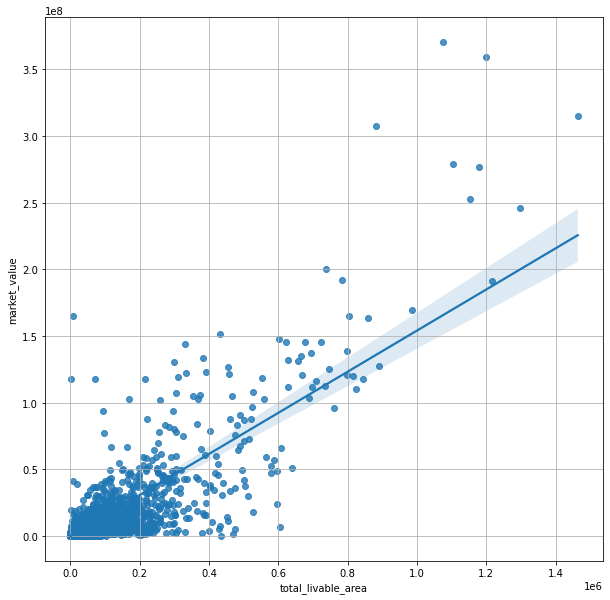

In [59]:
plt.figure(figsize=(10,10))
sns.regplot(data=df_predict, y='market_value', x='total_livable_area')
plt.grid()
plt.show()

From scatterplot above, we saw several contextual outliers with high market value. Since total livable area is correlated with number stories, let's check them using number stories column.

In [169]:
df_predict[(df_predict['total_livable_area']>1*1e6)&(df_predict['market_value']>2*1e8)][['market_value','number_stories','total_livable_area']].sort_values('market_value')

,market_value,number_stories,total_livable_area
468123,245769000.0,12.0,1296804.0
490480,252703800.0,41.0,1152480.0
469476,276892000.0,18.0,1179072.0
490666,278766900.0,44.0,1103287.0
489496,315046100.0,61.0,1464000.0
490665,358973100.0,58.0,1200021.0
490990,370556400.0,5.0,1076400.0


In [170]:
index=df_predict[df_predict['market_value']>360000000].index
df_predict.drop(index,inplace=True)

There is a property with low total livable area and high market value:

In [171]:
df_predict[(df_predict['market_value']>1.5*1e8)&(df_predict['total_livable_area']<2*1e5)]

,market_value,number_of_bedrooms,number_of_rooms,number_of_bathrooms,number_stories,overall_condition,property_age,sale_year,total_area,total_livable_area,category_code_description,central_air,fireplaces,new_zoning,other_building,parcel_shape,parking_spaces,street_designation,topography,unfinished,view_type,zip_code,building_code_description
460252,165198800.0,0.0,1.0,1.0,1.0,4.0,57.0,1943.0,7741883.0,6290.0,Commercial,0,0,Residential Single Family,N,E,0,RD,F,F,I,19154,MISC FIRE/POLICE MASONRY


Maybe that's because it has a lot of total area. Thus, we didn't dropped the data.

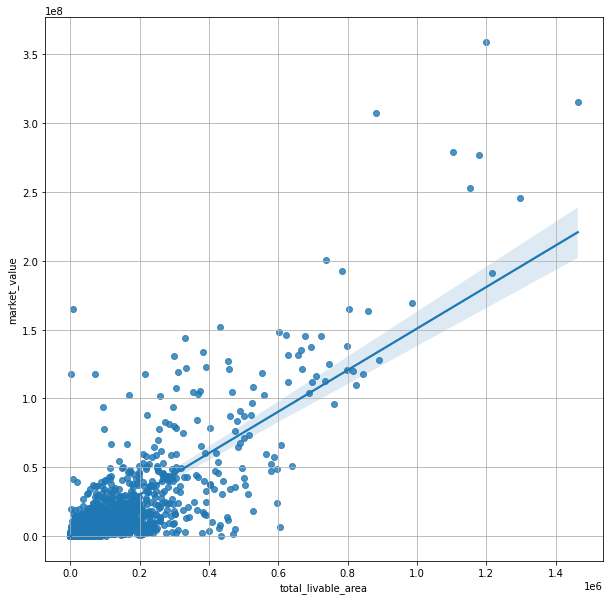

In [84]:
plt.figure(figsize=(10,10))
sns.regplot(data=df_predict, y='market_value', x='total_livable_area')
plt.grid()
plt.show()

## Total Area

Dropping data with super extreme value:

In [172]:
index=df_predict[df_predict['total_area']>1e8].index
df_predict.drop(index,inplace=True)

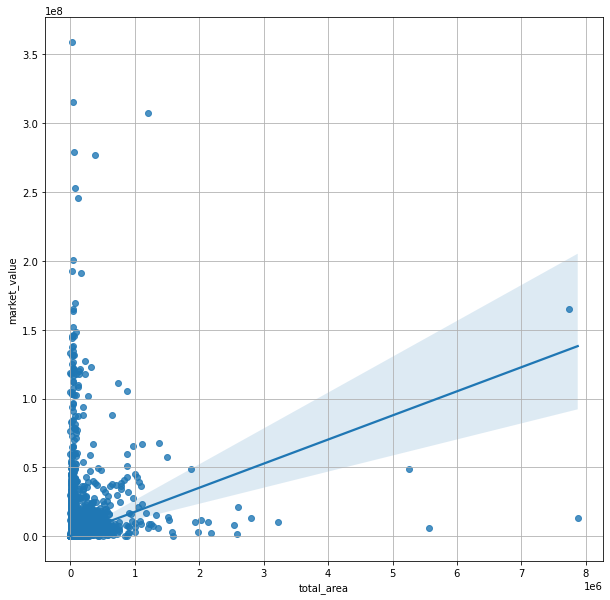

In [86]:
plt.figure(figsize=(10,10))
sns.regplot(data=df_predict, y='market_value', x='total_area')
plt.grid()
plt.show()

In [173]:
df_predict['total_area'].describe()

count    4.953860e+05
mean     2.969136e+03
std      2.739866e+04
min      1.000000e+00
25%      9.601100e+02
50%      1.360000e+03
75%      2.160000e+03
max      7.876084e+06
Name: total_area, dtype: float64

We need to clean total area before proceeding with deleting contextual outliers.

(array([2.8000e+01, 2.7100e+02, 2.4000e+02, 5.7100e+02, 1.8040e+03,
        6.7330e+03, 2.7446e+04, 3.3293e+04, 2.6757e+04, 4.0474e+04]),
 array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000]),
 <BarContainer object of 10 artists>)

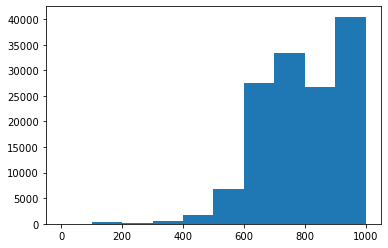

In [174]:
# Extreme Q1 value
plt.hist(df_predict['total_area'],bins=[0,100,200,300,400,500,600,700,800,900,1000])

Sudden decrease in property count with total area value below 600. Since it may be possible for building with low total area, let's drop data from 400 instead.

In [175]:
index=df_predict[df_predict['total_area']<400].index
df_predict.drop(index,inplace=True)

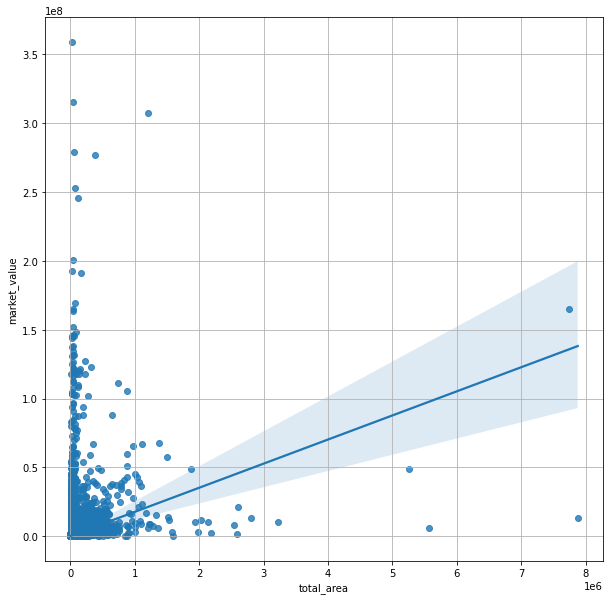

In [106]:
plt.figure(figsize=(10,10))
sns.regplot(data=df_predict, y='market_value', x='total_area')
plt.grid()
plt.show()

Now, let's drop contextual outliers. First, low total area but high market value.

In [176]:
df_predict[(df_predict['total_area']<1*1e6)&(df_predict['market_value']>1.5*1e8)].sort_values('market_value')

,market_value,number_of_bedrooms,number_of_rooms,number_of_bathrooms,number_stories,overall_condition,property_age,sale_year,total_area,total_livable_area,category_code_description,central_air,fireplaces,new_zoning,other_building,parcel_shape,parking_spaces,street_designation,topography,unfinished,view_type,zip_code,building_code_description
491317,151686300.0,0.0,4.0,1.0,18.0,4.0,46.0,2014.0,37400.00,431748.0,Commercial,0,0,Mixed Used,N,A,0,ST,F,F,I,19104,OFF BLD COM NO GAR MASON
489495,163646300.0,0.0,4.0,1.0,39.0,4.0,38.0,2018.0,35095.50,859989.0,Commercial,0,0,Mixed Used,N,E,0,ST,A,F,I,19103,OFF BLD COM NO GAR MASON
490986,164954700.0,0.0,4.0,1.0,34.0,3.0,35.0,1996.0,38016.00,803012.0,Commercial,0,0,Mixed Used,N,E,0,ST,F,F,I,19103,OFF BLD COM NO GAR MASON
490814,169697900.0,0.0,4.0,1.0,20.0,4.0,102.0,2016.0,69998.00,986960.0,Commercial,0,0,Mixed Used,N,A,0,ST,A,F,I,19106,OFF BLD COM NO GAR MASON
491787,191345600.0,0.0,4.0,1.0,12.0,4.0,72.0,2000.0,168780.64,1215492.0,Commercial,0,0,Mixed Used,N,E,0,ST,F,F,I,19130,OFF BLD COM NO GAR MASON
490988,192376800.0,0.0,4.0,1.0,28.0,3.0,15.0,2013.0,29633.00,782208.0,Commercial,0,0,Mixed Used,N,A,1,ST,F,F,I,19104,OFF BLD COM NO GAR MASON
469933,200287300.0,35.5,101.5,66.0,19.0,2.0,59.0,1995.0,38808.00,738207.0,Multi Family,0,0,Mixed Used,N,E,0,BLV,F,F,I,19103,APTS 100+ UNITS MASONRY
468123,245769000.0,0.0,4.0,1.0,12.0,4.0,91.0,2015.0,117931.00,1296804.0,Industrial,0,0,Industrial,N,A,1,ST,F,F,I,19108,IND WAREHOUSE MASONRY
490480,252703800.0,0.0,4.0,1.0,41.0,4.0,29.0,1997.0,64431.00,1152480.0,Commercial,0,0,Mixed Used,N,E,0,ST,F,F,I,19103,OFF BLD COM NO GAR MASON
469476,276892000.0,35.5,101.5,66.0,18.0,2.0,61.0,1996.0,387684.00,1179072.0,Multi Family,0,0,Residential Multi Family,N,A,0,PL,F,F,I,19130,APTS 100+ UNITS MASONRY


It still possible for properties to have low total area, since the property has a lot of stories. However, it's strange that property with 18 floor to only have 1 bathrooms. Let's drop those data.

In [177]:
index=df_predict[(df_predict['total_area']<1*1e6)&(df_predict['market_value']>1.5*1e8)&(df_predict['number_of_bathrooms']<5)].index
df_predict.drop(index,inplace=True)

Let's check data with high total area but low market value.

In [178]:
df_predict[(df_predict['total_area']>3*1e6)&(df_predict['market_value']<1e8)]

,market_value,number_of_bedrooms,number_of_rooms,number_of_bathrooms,number_stories,overall_condition,property_age,sale_year,total_area,total_livable_area,category_code_description,central_air,fireplaces,new_zoning,other_building,parcel_shape,parking_spaces,street_designation,topography,unfinished,view_type,zip_code,building_code_description
461430,13376000.0,0.0,4.0,1.0,1.0,4.0,70.0,2011.0,7876084.0,100000.0,Industrial,0,0,Industrial,N,E,1,ST,F,F,I,19112,IND WAREHOUSE MASONRY
467973,48627400.0,35.5,101.5,66.0,2.0,4.0,68.0,1952.0,5248824.0,597188.0,Multi Family,0,0,Residential Multi Family,N,B,1,ST,F,F,I,19136,APTS 100+ UNITS MASONRY
469131,5948600.0,0.0,5.5,1.0,1.0,4.0,15.0,2008.0,5570888.4,2220.0,Commercial,0,0,Industrial,N,B,0,ST,F,F,I,19112,OFF BLD N/PKG N/COM MASON
486911,9980400.0,0.0,0.0,0.0,0.0,4.0,95.0,1952.0,3223200.0,6756.0,Commercial,0,0,Residential Single Family,N,E,0,AVE,F,F,I,19142,CEMETERY


In [179]:
index=df_predict[(df_predict['total_area']>3*1e6)&(df_predict['market_value']<0.4*1e8)].index
df_predict.drop(index,inplace=True)

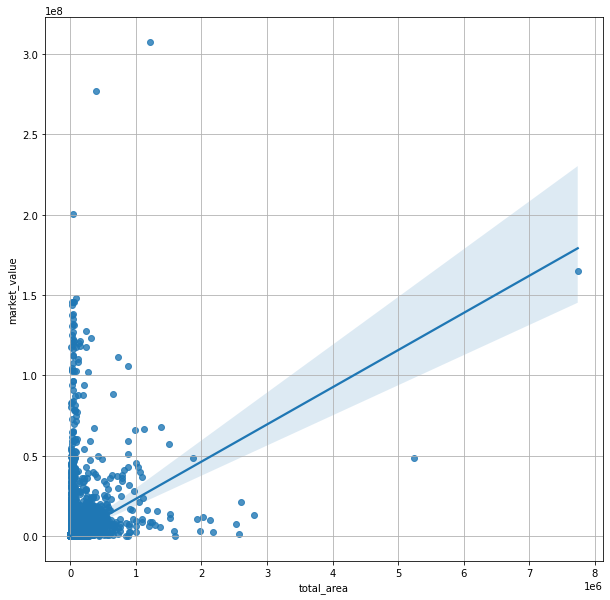

In [116]:
plt.figure(figsize=(10,10))
sns.regplot(data=df_predict, y='market_value', x='total_area')
plt.grid()
plt.show()

## Final Data Visualization

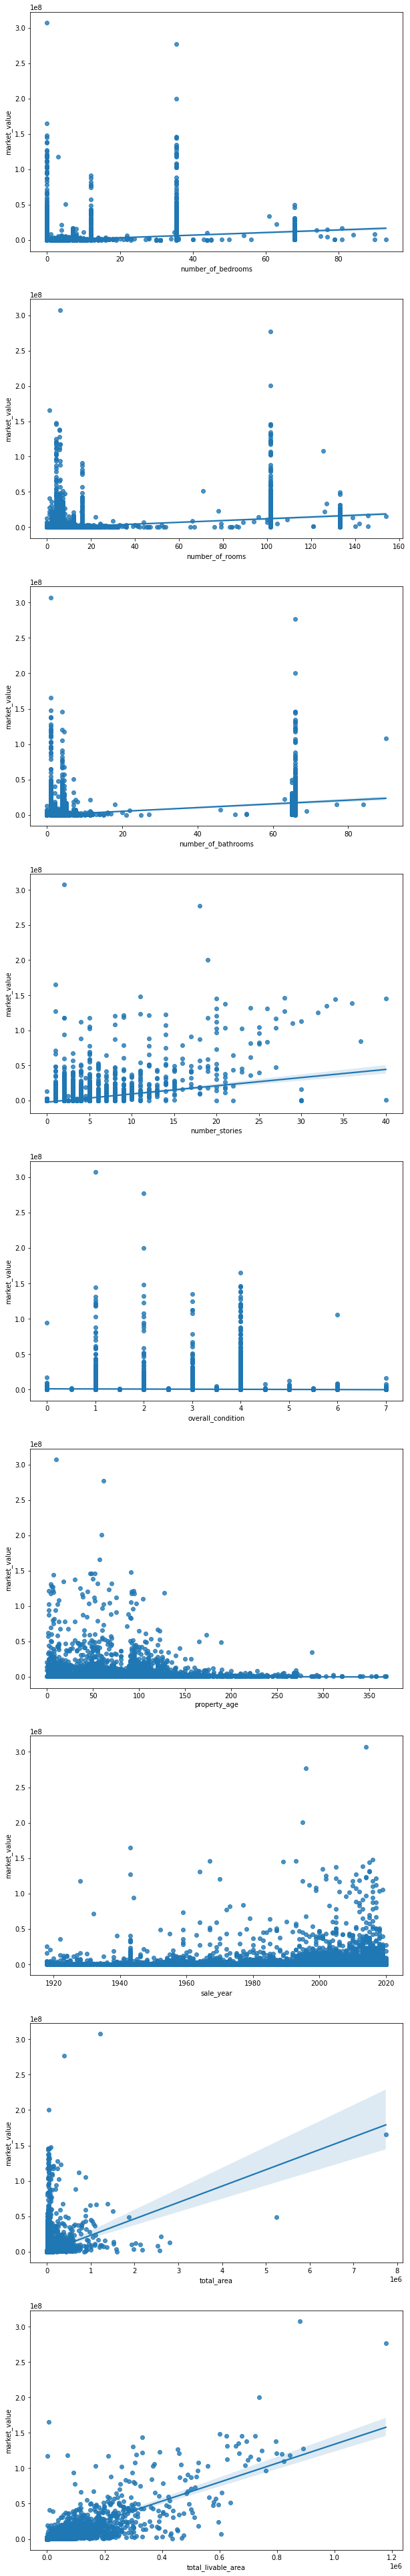

In [117]:
fig, ax = plt.subplots(9,1, figsize=(10,70))
for variable, subplot in zip(['number_of_bedrooms','number_of_rooms','number_of_bathrooms','number_stories',
                              'overall_condition','property_age','sale_year','total_area','total_livable_area'], ax.flatten()):
    sns.regplot(data=df_predict, y='market_value', x=variable, ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(0)

In [180]:
df_predict.reset_index(drop=True, inplace=True)

# Base Model

## Data Pre-Processing Scheme

In [181]:
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494262 entries, 0 to 494261
Data columns (total 23 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   market_value               494262 non-null  float64
 1   number_of_bedrooms         494262 non-null  float64
 2   number_of_rooms            494262 non-null  float64
 3   number_of_bathrooms        494262 non-null  float64
 4   number_stories             494262 non-null  float64
 5   overall_condition          494262 non-null  float64
 6   property_age               494262 non-null  float64
 7   sale_year                  494262 non-null  float64
 8   total_area                 494262 non-null  float64
 9   total_livable_area         494262 non-null  float64
 10  category_code_description  494262 non-null  object 
 11  central_air                494262 non-null  object 
 12  fireplaces                 494262 non-null  object 
 13  new_zoning                 49

From outlier trimming using contextual outlier analysis, the data had 494.262 data with 20 features.

**Label**: market_value

**Feature**:
- **Numerical**:
    1. number_of_bedrooms
    2. number_of_rooms
    3. number_stories
    4. overall_condition
    5. property_age
    6. sale_year
    7. total_area
    8. total_livable_area  
    
    
- **Categorical**:
    9. category_code_description
    10. central_air
    11. fireplaces
    12. new_zoning
    13. other_building
    14. parcel_shape
    15. parking_spaces
    16. street_designation
    17. topography
    18. unfinished
    19. view_type
    20. zip_code

### Encoding

**`Binary encoding`**
1. category_code_description; 6 unique value
2. fireplaces; 5 unique value
3. new_zoning; 11 unique value
4. parcel_shape; 5 unique value
5. parking_spaces; 7 unique value
6. street_designation; 23 unique value
7. topography; 7 unique value
8. view_type; 8 unique value
9. zip_code; 52 unique value

**`One hot encoding`**
1. central_air; 3 unique value
2. other_building; 2 unique value
3. unfinished; 2 unique value

### Scaling

**`Robust Scaling`**:
1. total_area
2. total_livable_area
3. property_age

**`Didn't preprocessed:`**
1. number_of_bedrooms
2. number_of_rooms
2. number_stories 
3. overall_condition
4. sale_year

### Transformer

In [140]:
transformer= ColumnTransformer([
    ('one hot', OneHotEncoder(drop='first'),['central_air','other_building','unfinished']),
    ('binary', ce.BinaryEncoder(),['category_code_description','fireplaces','new_zoning',
                                   'parcel_shape','parking_spaces','street_designation','topography','view_type','zip_code']),
    ('scaling', RobustScaler(),['total_area','total_livable_area','property_age'])
], remainder='passthrough')

In [141]:
transformer.fit_transform(df_predict)

array([[1.000e+00, 0.000e+00, 0.000e+00, ..., 3.000e+00, 5.000e+00,
        1.951e+03],
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 3.000e+00, 2.000e+00,
        2.017e+03],
       [1.000e+00, 0.000e+00, 0.000e+00, ..., 2.000e+00, 4.000e+00,
        1.975e+03],
       ...,
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 3.000e+00, 1.000e+00,
        2.015e+03],
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 3.000e+00, 1.000e+00,
        2.018e+03],
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 4.000e+00, 2.000e+00,
        2.019e+03]])

## Data Splitting

In [182]:
y=df_predict['market_value']
x=df_predict.drop(columns=['market_value','building_code_description'])

In [183]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=2020)

## Pipeline Function

In this project, we only use 3 models. Linear regression will be the representation of parametric model of regression, while random forest and XGBoost regressor will be the representation of ensemble model of nonparametric model of regression. Random forest was representing bagging method, and XGBoost regressor was representing boosting method.

In [149]:
linreg=LinearRegression()
forest=RandomForestRegressor(random_state=2020)
xgb=XGBRegressor(random_state=2020)

In [150]:
linreg_pipe=Pipeline([
    ('preprocessing',transformer),
    ('model',linreg)
])
forest_pipe=Pipeline([
    ('preprocessing',transformer),
    ('model',forest)
])
xgb_pipe=Pipeline([
    ('preprocessing',transformer),
    ('model',xgb)
])

## Model Benchmarking

### Evaluation Metrics

In regression model, there are several evaluation metrics that can be used to evaluate our model:
1. R-squared
2. Mean squared error (MSE)
3. Root mean squared error (RMSE)
4. Mean absolute error (MAE)
5. Mean absolute percentage error (MAPE)

The selection process of evaluation metric must be adjusted to the business problem stated in the background. Considering the high variance of market value of property stated in detailed EDA, the usage of MSE and RMSE will also lead to high variance in error/residual, biasing the result. MAE will be more representative for market value, but considering the presence of very extreme outliers, changing the residual into percentage (MAPE) will be representative and just to all range of market value properties.

### Cross-validation

In [151]:
models=[linreg_pipe,forest_pipe,xgb_pipe]
score=[]
mean_score=[]
std_score=[]

for i in models:
    model_cv=cross_val_score(i,x_train,y_train,scoring='neg_mean_absolute_percentage_error', cv=5, n_jobs=-1)
    score.append(model_cv)
    mean_score.append(model_cv.mean())
    std_score.append(model_cv.std())

pd.DataFrame({
    'model': ['LinReg','Forest','XGB'],
    'mean': mean_score,
    'std': std_score
})

,model,mean,std
0,LinReg,-1.104495,0.063067
1,Forest,-0.144023,0.002121
2,XGB,-0.333862,0.011235


From cross validation result above, random forest was proven to be the best model with MAPE of 14.4% and the lowest standard deviation compared to other models.

## Random Forest Model Performance

In [152]:
forest_pipe.fit(x_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['central_air',
                                                   'other_building',
                                                   'unfinished']),
                                                 ('binary', BinaryEncoder(),
                                                  ['category_code_description',
                                                   'fireplaces', 'new_zoning',
                                                   'parcel_shape',
                                                   'parking_spaces',
                                                   'street_designation',
                                                   'topography', 'view_type',
                                         

In [153]:
y_pred_forest=forest_pipe.predict(x_test)

In [154]:
forest_result=pd.DataFrame({'Actual':y_test, 'Prediction': y_pred_forest})
forest_result

,Actual,Prediction
300895,133000.0,132106.0
283957,114800.0,116038.0
333793,46100.0,46196.0
276719,46800.0,46800.0
480091,536400.0,625879.0
...,...,...
185032,101400.0,95761.0
352770,71100.0,71726.0
226743,980000.0,876870.0
404181,137300.0,132182.0


In [156]:
print("MAPE SCORE: ",mean_absolute_percentage_error(y_test,y_pred_forest))
print("MAE SCORE: ",mean_absolute_error(y_test,y_pred_forest))
print("MSE SCORE: ",mean_squared_error(y_test,y_pred_forest))
print("RMSE SCORE: ",np.sqrt(mean_squared_error(y_test,y_pred_forest)))
print ("R2 SCORE: ", r2_score(y_test,y_pred_forest))

MAPE SCORE:  0.14723232959544144
MAE SCORE:  45638.14170757707
MSE SCORE:  509538132165.00476
RMSE SCORE:  713819.3974423816
R2 SCORE:  0.846360783510928


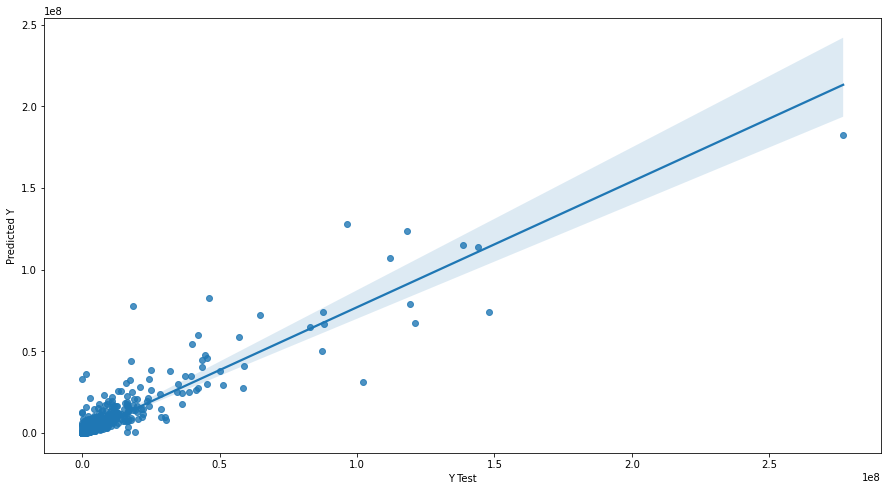

In [157]:
plt.figure(figsize=(15,8))
sns.regplot(x=y_test, y=y_pred_forest,fit_reg=True)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

# Model with Feature Engineering

Can we improve the model with feature engineering?

## Feature Engineering

### Distance to City Center

Based from folium analysis in detailed EDA, distance to city center affects the market price. Let's create the column based on zip code.

In [184]:
df_predict['zip_code']=df_predict['zip_code'].apply(lambda x: int(x))

In [185]:
df_predict['distance_city_center']=df_predict['zip_code'].apply(lambda x: 
                                                'City Center' if x in ([19103,19102,19107,19106,19130,19123,19146,19147]) else
                                                'Adjacent City Center' if x in([19121, 19122, 19125, 19145, 19148, 19104]) else
                                                'Near City Center' if x in([19112, 19153, 19142, 19143, 19139, 19151, 19131, 19132, 19133, 19134]) else
                                                'Far From City Center' if x in([19129, 19140, 19124, 19137, 19144, 19141, 19120, 19135, 19149]) else
                                                'Very Far From City Center NW' if x in([19128, 19118, 19119, 19150, 19138, 19126, 19127]) else
                                                'Very Far From City Center NE' if x in([19111, 19152, 19136, 19115, 19114, 19116, 19154]) else 'Other')

In [186]:
df_predict['distance_city_center'].value_counts()

Near City Center                125129
Far From City Center            120324
Very Far From City Center NE     75808
Adjacent City Center             74956
Very Far From City Center NW     52678
City Center                      45363
Other                                4
Name: distance_city_center, dtype: int64

### Simplify Fireplaces

It's rare for customers to consider the amount of fireplaces in the property.

In [187]:
df_predict['have_fireplaces']=df_predict['fireplaces'].apply(lambda x: 0 if x=='0' else 1)

In [188]:
df_predict['have_fireplaces'].value_counts()

0    480713
1     13549
Name: have_fireplaces, dtype: int64

### Extracting Informations from Building Code Description

In [189]:
#list word in building_code_description that can describe everything other than house
list1=['CONDO','PARKING','SPACE','LOFT','MISC','APT','HOTEL','MOTEL','OFF','STR','STORE','WORSHIP','AUTO','PKG','BLD','SCHOOL',
 'REST','BAR','CARE','HEALTH','PARK','AMUSE','VACANT','TAVERN','CLEANING','CEMETERY','WAREHOUSE','MFG','JUNKYARD','VACANT']

#### Condominium

In [190]:
df_predict[((df_predict['building_code_description'].str.contains('CONDO')))&(~df_predict['building_code_description'].str.contains('PARKING'))].index

Int64Index([459290, 479902, 479956, 479961, 480104, 480105, 480176, 480177,
            480178, 480179,
            ...
            494252, 494253, 494254, 494255, 494256, 494257, 494258, 494259,
            494260, 494261],
           dtype='int64', length=825)

In [191]:
df_predict['condominium']=df_predict['building_code_description'].apply(lambda x: 1 if (('CONDO' in x)&('PARKING' not in x)) else 0)

In [192]:
df_predict['condominium'].sum()

825

#### Apartments

In [193]:
df_predict[((df_predict['building_code_description'].str.contains('APT')))].index

Int64Index([   110,    119,    189,    259,    347,    354,    362,    363,
               364,    382,
            ...
            493575, 493576, 493577, 493578, 493585, 493586, 493587, 493588,
            493589, 493590],
           dtype='int64', length=48593)

In [194]:
df_predict['apartment']=df_predict['building_code_description'].apply(lambda x: 1 if ('APT' in x) else 0)

In [195]:
df_predict['apartment'].sum()

48593

#### House

In [196]:
df_predict[~df_predict['building_code_description'].str.contains('|'.join(list1))].index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            493566, 493567, 493568, 493571, 493579, 493580, 493581, 493582,
            493583, 493584],
           dtype='int64', length=425441)

In [197]:
house_index=df_predict[~df_predict['building_code_description'].str.contains('|'.join(list1))].index

In [199]:
df_predict['house']=[0] * len(df_predict)

In [200]:
len(df_predict['house'])

494262

In [201]:
df_predict.loc[house_index,'house']=1

In [202]:
df_predict['house'].sum()

425441

#### Others

In [203]:
df_predict[(df_predict['building_code_description'].str.contains('|'.join(list1)))&(~df_predict['building_code_description'].str.contains('APT'))&~((df_predict['building_code_description'].str.contains('CONDO'))&(~df_predict['building_code_description'].str.contains('PARKING')))].index

Int64Index([  2809,   3836,  13332,  15053,  15195,  16068,  16084,  16949,
             17013,  17059,
            ...
            493514, 493845, 493846, 493847, 493848, 493849, 493850, 493851,
            493852, 493853],
           dtype='int64', length=19403)

In [204]:
other_index=df_predict[(df_predict['building_code_description'].str.contains('|'.join(list1)))&
               (~df_predict['building_code_description'].str.contains('APT'))&
               ~((df_predict['building_code_description'].str.contains('CONDO'))&
                 (~df_predict['building_code_description'].str.contains('PARKING')))].index

In [205]:
df_predict['other']=[0] * len(df_predict)

In [206]:
len(df_predict['other'])

494262

In [207]:
df_predict.loc[other_index,'other']=1

In [208]:
df_predict['other'].sum()

19403

In [209]:
(df_predict['apartment']+df_predict['condominium']+df_predict['house']+df_predict['other']).sum()

494262

In [210]:
((df_predict['apartment']+df_predict['condominium']+df_predict['house']+df_predict['other'])!=1).sum()

0

In [211]:
df_predict.drop(columns='other',inplace=True)

The 'other' column was dropped, since it already represented in 0 value in 'apartment', 'condominium', and 'house' columns.

## Data Pre-Processing Scheme

The same with point 5.1. But with addition of:  
1. Distance to city center: Binary encoding
2. Having fireplaces: Passthrough, was manually encoded
3. Condominium, House, Others: Passthrough, was manually encoded

### Transformer

In [214]:
transformer= ColumnTransformer([
    ('one hot', OneHotEncoder(drop='first'),['central_air','other_building','unfinished']),
    ('binary', ce.BinaryEncoder(),['category_code_description','distance_city_center','new_zoning','parcel_shape',
                                   'parking_spaces','street_designation','topography','view_type','zip_code']),
    ('scaling', RobustScaler(),['total_area','total_livable_area','property_age'])
], remainder='passthrough')

## Data Splitting

In [416]:
y=df_predict['market_value']
x=df_predict.drop(columns=['market_value','building_code_description','fireplaces'])

In [417]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=2020)

## Pipeline Function

Let's crosscheck just to make sure.

In [418]:
linreg=LinearRegression()
forest=RandomForestRegressor(random_state=2020)
xgb=XGBRegressor(random_state=2020)

In [419]:
linreg_pipe=Pipeline([
    ('preprocessing',transformer),
    ('model',linreg)
])
forest_pipe=Pipeline([
    ('preprocessing',transformer),
    ('model',forest)
])
xgb_pipe=Pipeline([
    ('preprocessing',transformer),
    ('model',xgb)
])

## Model Benchmarking

### Cross-validation

In [222]:
models=[linreg_pipe,forest_pipe,xgb_pipe]
score=[]
mean_score=[]
std_score=[]

for i in models:
    model_cv=cross_val_score(i,x_train,y_train,scoring='neg_mean_absolute_percentage_error', cv=5, n_jobs=-1)
    score.append(model_cv)
    mean_score.append(model_cv.mean())
    std_score.append(model_cv.std())

pd.DataFrame({
    'model': ['LinReg','Forest','XGB'],
    'mean': mean_score,
    'std': std_score
})

,model,mean,std
0,LinReg,-1.121933,0.059290
1,Forest,-0.136513,0.006065
2,XGB,-0.297244,0.004322


## Random Forest Model Performance

In [420]:
forest_pipe.fit(x_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['central_air',
                                                   'other_building',
                                                   'unfinished']),
                                                 ('binary', BinaryEncoder(),
                                                  ['category_code_description',
                                                   'distance_city_center',
                                                   'new_zoning', 'parcel_shape',
                                                   'parking_spaces',
                                                   'street_designation',
                                                   'topography', 'view_type',
                               

In [421]:
y_pred_forest=forest_pipe.predict(x_test)

In [422]:
forest_result=pd.DataFrame({'Actual':y_test, 'Prediction': y_pred_forest})
forest_result

,Actual,Prediction
300183,133000.0,1.306820e+05
283253,114800.0,1.157080e+05
333070,46100.0,4.621500e+04
276019,46800.0,4.680000e+04
479329,536400.0,6.390560e+05
...,...,...
184363,101400.0,9.618100e+04
352046,71100.0,7.111133e+04
226066,980000.0,1.133967e+06
403449,137300.0,1.306380e+05


In [423]:
print("MAPE SCORE: ",mean_absolute_percentage_error(y_test,y_pred_forest))
print("MAE SCORE: ",mean_absolute_error(y_test,y_pred_forest))
print("MSE SCORE: ",mean_squared_error(y_test,y_pred_forest))
print("RMSE SCORE: ",np.sqrt(mean_squared_error(y_test,y_pred_forest)))
print ("R2 SCORE: ", r2_score(y_test,y_pred_forest))

MAPE SCORE:  0.14064928177303548
MAE SCORE:  44168.17624770407
MSE SCORE:  562290728860.8242
RMSE SCORE:  749860.4729286804
R2 SCORE:  0.830454481092162


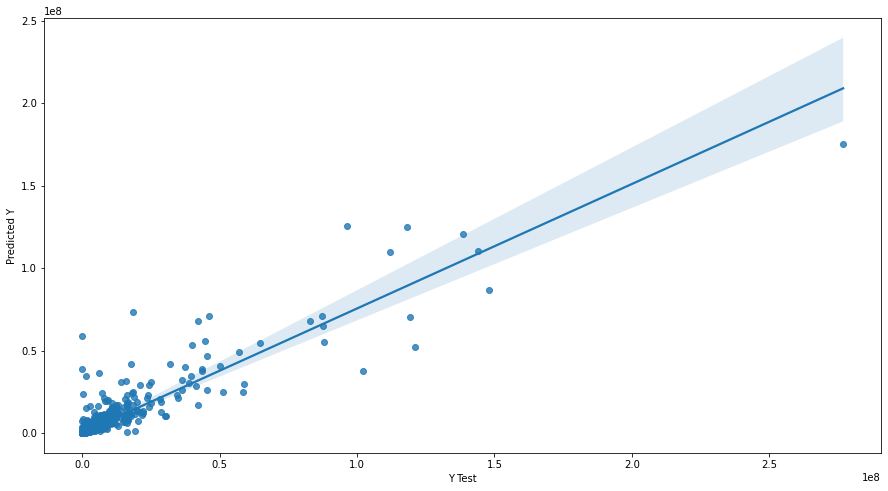

In [227]:
plt.figure(figsize=(15,8))
sns.regplot(x=y_test, y=y_pred_forest,fit_reg=True)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

Feature engineering really improve the performance of the model. Let's try hyperparameter tuning.

# Model with Hyperparameter Tuning

## Randomized Search CV

In [228]:
forest_pipe.get_params()

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('one hot', OneHotEncoder(drop='first'),
                                    ['central_air', 'other_building',
                                     'unfinished']),
                                   ('binary', BinaryEncoder(),
                                    ['category_code_description',
                                     'distance_city_center', 'new_zoning',
                                     'parcel_shape', 'parking_spaces',
                                     'street_designation', 'topography',
                                     'view_type', 'zip_code']),
                                   ('scaling', RobustScaler(),
                                    ['total_area', 'total_livable_area',
                                     'property_age'])])),
  ('model', RandomForestRegressor(random_state=2020))],
 'verbose': False,
 'preprocessing': ColumnTran

In [229]:
# Choosing parameter
criterion=['squared_error','absolute_error']
max_depth=[2,3,4,5,6,7]
min_samples_leaf=[5,10,15,20,25,30,35,40,45,50,60,70,80,90,100]
min_samples_split=[5,10,15,20,25,30,35,40,45,50,60,70,80,90,100]

forest_param={
    'model__criterion':criterion,
    'model__max_depth':max_depth,
    'model__min_samples_leaf':min_samples_leaf,
    'model__min_samples_split':min_samples_split,
}

We failed to do hyperparameter tuning due to massive dataset resulting in extremely long execution of model fitting. Out computational power were not enough. We already tried:
1. GridSearchCV
2. RandomizedSearchCV
3. HalvingGridSearchCV

Thus, we will use model from feature engineering only.

The closest almost done process we got (with verbose):

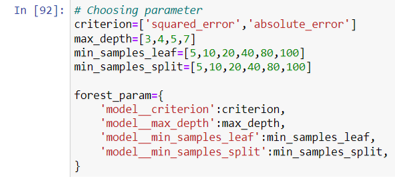

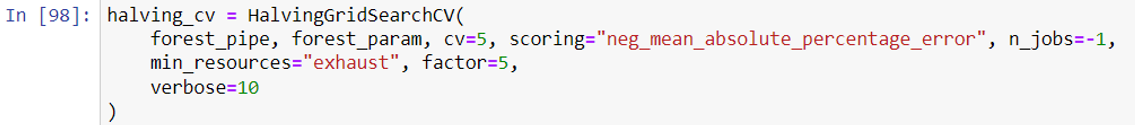

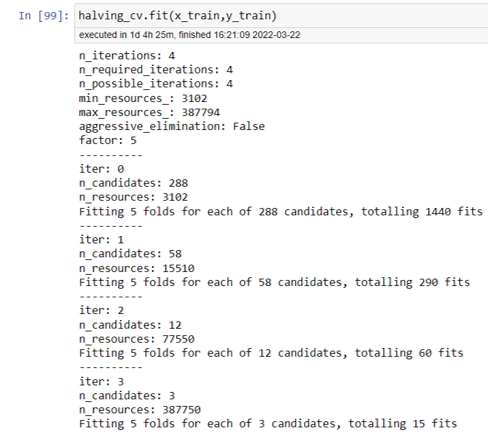

Failed at executing iter 3, thus manually reviewing the results at [Notes 1](https://drive.google.com/file/d/13aYZjEM5SfU-JTUiSG23gpnufYJoFSRM/view?usp=sharing) and [Notes 2](https://drive.google.com/file/d/1j0PbTriCujqTTGraC6ICG6NEksE4nHbZ/view?usp=sharing).

Taking the best score, but even with single model (CV=5), 2 days running and still not done, we interrupt the process.

# Feature Importance

In [234]:
forest_pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['central_air',
                                                   'other_building',
                                                   'unfinished']),
                                                 ('binary', BinaryEncoder(),
                                                  ['category_code_description',
                                                   'distance_city_center',
                                                   'new_zoning', 'parcel_shape',
                                                   'parking_spaces',
                                                   'street_designation',
                                                   'topography', 'view_type',
                               

In [253]:
# Get feature name from One Hot Encoder
forest_pipe[0].transformers_[0][1].get_feature_names_out()

array(['central_air_N', 'central_air_Y', 'other_building_Y',
       'unfinished_U'], dtype=object)

In [236]:
#Get feature name from Binary Encoder
forest_pipe[0].transformers_[1][1].get_feature_names()

['category_code_description_0',
 'category_code_description_1',
 'category_code_description_2',
 'distance_city_center_0',
 'distance_city_center_1',
 'distance_city_center_2',
 'new_zoning_0',
 'new_zoning_1',
 'new_zoning_2',
 'new_zoning_3',
 'parcel_shape_0',
 'parcel_shape_1',
 'parcel_shape_2',
 'parking_spaces_0',
 'parking_spaces_1',
 'parking_spaces_2',
 'street_designation_0',
 'street_designation_1',
 'street_designation_2',
 'street_designation_3',
 'street_designation_4',
 'topography_0',
 'topography_1',
 'topography_2',
 'view_type_0',
 'view_type_1',
 'view_type_2',
 'view_type_3',
 'zip_code']

In [255]:
x.columns

Index(['number_of_bedrooms', 'number_of_rooms', 'number_of_bathrooms',
       'number_stories', 'overall_condition', 'property_age', 'sale_year',
       'total_area', 'total_livable_area', 'category_code_description',
       'central_air', 'new_zoning', 'other_building', 'parcel_shape',
       'parking_spaces', 'street_designation', 'topography', 'unfinished',
       'view_type', 'zip_code', 'distance_city_center', 'have_fireplaces',
       'condominium', 'apartment', 'house'],
      dtype='object')

In [256]:
#Combine all of the feature name after encoding
features = list(forest_pipe[0].transformers_[0][1].get_feature_names_out()) + forest_pipe[0].transformers_[1][1].get_feature_names() + ['number_of_bedrooms','number_of_rooms','number_of_bathrooms','number_stories','overall_condition',
                                                                                                                                        'property_age','sale_year','total_area','total_livable_area','have_fireplaces','condominium','apartment','house']
features

['central_air_N',
 'central_air_Y',
 'other_building_Y',
 'unfinished_U',
 'category_code_description_0',
 'category_code_description_1',
 'category_code_description_2',
 'distance_city_center_0',
 'distance_city_center_1',
 'distance_city_center_2',
 'new_zoning_0',
 'new_zoning_1',
 'new_zoning_2',
 'new_zoning_3',
 'parcel_shape_0',
 'parcel_shape_1',
 'parcel_shape_2',
 'parking_spaces_0',
 'parking_spaces_1',
 'parking_spaces_2',
 'street_designation_0',
 'street_designation_1',
 'street_designation_2',
 'street_designation_3',
 'street_designation_4',
 'topography_0',
 'topography_1',
 'topography_2',
 'view_type_0',
 'view_type_1',
 'view_type_2',
 'view_type_3',
 'zip_code',
 'number_of_bedrooms',
 'number_of_rooms',
 'number_of_bathrooms',
 'number_stories',
 'overall_condition',
 'property_age',
 'sale_year',
 'total_area',
 'total_livable_area',
 'have_fireplaces',
 'condominium',
 'apartment',
 'house']

In [259]:
importance_table=pd.DataFrame({'importance': forest_pipe[1].feature_importances_}, index=features)
importance_table.sort_values(by='importance', ascending=False)

,importance
number_of_rooms,0.714192
zip_code,0.057477
number_of_bedrooms,0.050885
sale_year,0.032239
total_area,0.022050
number_of_bathrooms,0.021937
total_livable_area,0.019919
new_zoning_0,0.013652
category_code_description_2,0.008173
property_age,0.006274


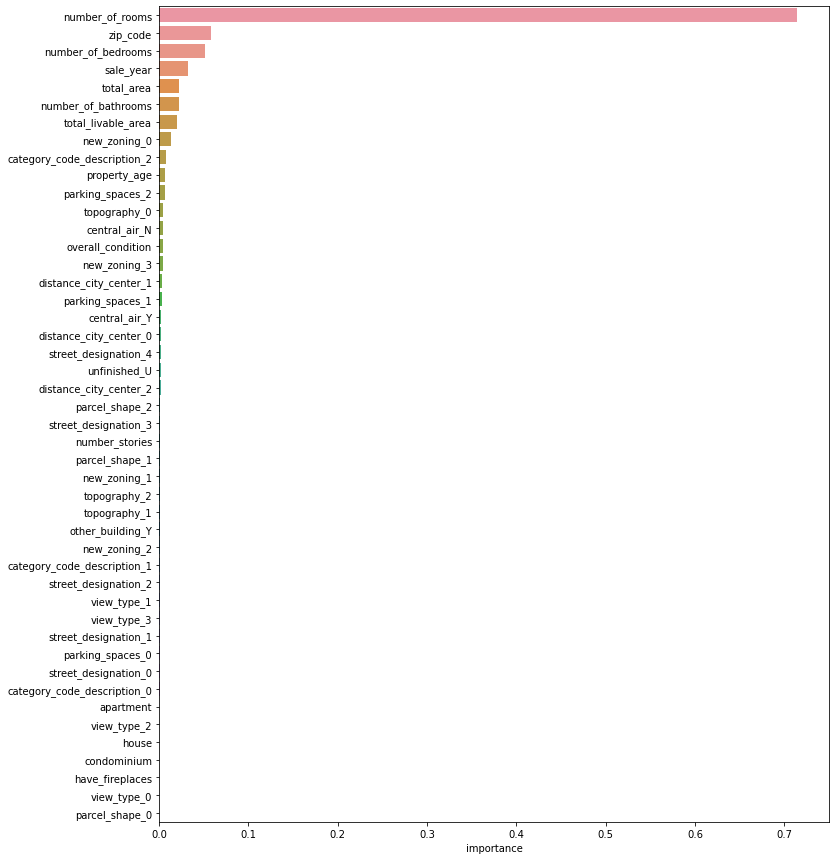

In [260]:
plt.figure(figsize=(12,15))
sns.barplot(data=importance_table.sort_values(by='importance', ascending=False), 
            x='importance', y=importance_table.sort_values(by='importance', ascending=False).index, orient='h')
plt.show()

Top 10 features: 
1. Number of rooms, 
2. Zip code, 
3. Number of bedrooms, 
4. Sale year, 
5. Total area, 
6. Number of bathrooms,
7. Total livable area,
8. Zoning,
9. Category code description,
10. Property age.

# Residual Analysis

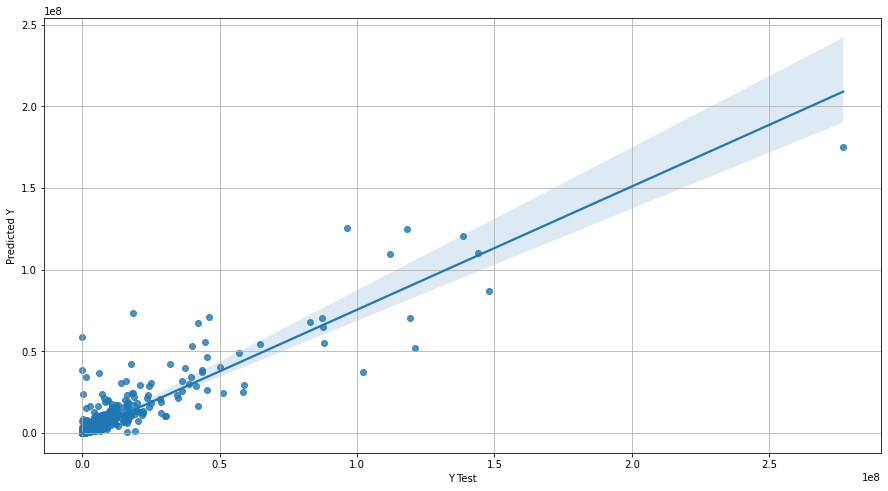

In [424]:
plt.figure(figsize=(15,8))
sns.regplot(x=y_test, y=y_pred_forest,fit_reg=True)
plt.grid()
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

In [425]:
forest_result['Percentage Error']=(forest_result['Prediction']-forest_result['Actual'])/forest_result['Actual']*100

In [427]:
forest_result['Percentage Error Abs']=abs(forest_result['Percentage Error'])

In [428]:
forest_result

,Actual,Prediction,Percentage Error,Percentage Error Abs
300183,133000.0,1.306820e+05,-1.742857,1.742857
283253,114800.0,1.157080e+05,0.790941,0.790941
333070,46100.0,4.621500e+04,0.249458,0.249458
276019,46800.0,4.680000e+04,0.000000,0.000000
479329,536400.0,6.390560e+05,19.137957,19.137957
...,...,...,...,...
184363,101400.0,9.618100e+04,-5.146943,5.146943
352046,71100.0,7.111133e+04,0.015940,0.015940
226066,980000.0,1.133967e+06,15.710918,15.710918
403449,137300.0,1.306380e+05,-4.852149,4.852149


In [431]:
forest_result['Percentage Error Abs'].describe()

count    98853.000000
mean        14.064928
std        267.758470
min          0.000000
25%          0.257314
50%          2.164634
75%         10.809524
max      68101.981439
Name: Percentage Error Abs, dtype: float64

In [430]:
forest_result[forest_result['Percentage Error Abs']<20]['Percentage Error Abs'].describe()

count    84053.000000
mean         3.683431
std          4.936256
min          0.000000
25%          0.161852
50%          1.251634
75%          5.534783
max         19.999074
Name: Percentage Error Abs, dtype: float64

In [269]:
forest_result=forest_result.join(df_predict, how='inner').reset_index(drop=True)

In [271]:
forest_result

,Actual,Prediction,Percentage Error,market_value,number_of_bedrooms,number_of_rooms,number_of_bathrooms,number_stories,overall_condition,property_age,sale_year,total_area,total_livable_area,category_code_description,central_air,fireplaces,new_zoning,other_building,parcel_shape,parking_spaces,street_designation,topography,unfinished,view_type,zip_code,building_code_description,distance_city_center,have_fireplaces,condominium,apartment,house,Percentage Error Abs
0,133000.0,1.306820e+05,-1.742857,133000.0,3.0,6.0,1.0,2.0,4.0,95.0,1979.0,1455.00,1290.0,Single Family,0,0,Residential Multi Family,N,E,0,AVE,F,F,I,19143,ROW 2 STY MASONRY,Near City Center,0,0,0,1,1.742857
1,114800.0,1.157080e+05,0.790941,114800.0,3.0,6.0,1.0,2.0,4.0,70.0,2007.0,3334.56,1216.0,Single Family,0,0,Residential Single Family,N,E,1,ST,F,F,I,19120,ROW B/GAR 2 STY MASONRY,Far From City Center,0,0,0,1,0.790941
2,46100.0,4.621500e+04,0.249458,46100.0,3.0,6.0,1.0,2.0,4.0,95.0,1972.0,912.00,992.0,Single Family,0,0,Residential Multi Family,N,E,0,ST,F,F,I,19143,ROW 2 STY MASONRY,Near City Center,0,0,0,1,0.249458
3,46800.0,4.680000e+04,0.000000,46800.0,3.0,6.0,1.0,2.0,4.0,95.0,2004.0,1500.00,1755.0,Single Family,N,0,Residential Multi Family,N,E,0,ST,F,F,I,19140,ROW 2 STY MASONRY,Far From City Center,0,0,0,1,0.000000
4,536400.0,6.390560e+05,19.137957,536400.0,4.0,6.0,2.0,3.0,3.0,220.0,2006.0,783.00,1734.0,Mixed Use,Y,1,Residential Multi Family,N,E,0,ST,A,F,I,19146,STR/OFF+APT 3 STY MASONRY,City Center,1,0,1,0,19.137957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98848,101400.0,9.618100e+04,-5.146943,101400.0,3.0,6.0,1.0,2.0,4.0,95.0,2008.0,1218.00,1312.0,Single Family,0,0,Residential Multi Family,N,E,0,ST,F,F,I,19151,ROW 2 STY MASONRY,Near City Center,0,0,0,1,5.146943
98849,71100.0,7.111133e+04,0.015940,71100.0,3.0,6.0,1.0,2.0,5.0,95.0,2007.0,1680.00,1402.0,Single Family,0,0,Residential Single Family,N,E,1,ST,F,F,I,19131,ROW B/GAR 2 STY MASONRY,Near City Center,0,0,0,1,0.015940
98850,980000.0,1.133967e+06,15.710918,980000.0,9.0,16.0,6.0,3.0,1.0,2.0,2018.0,2546.00,4881.0,Multi Family,Y,0,Mixed Used,N,E,0,ST,F,F,I,19146,APT 2-4 UNITS 3 STY MASON,City Center,0,0,1,0,15.710918
98851,137300.0,1.306380e+05,-4.852149,137300.0,3.0,6.0,1.0,2.0,3.0,95.0,2011.0,1120.00,1224.0,Single Family,0,0,Residential Multi Family,N,E,0,AVE,F,F,I,19143,ROW 2 STY MASONRY,Near City Center,0,0,0,1,4.852149


In [273]:
forest_result[forest_result['Percentage Error Abs']>20]

,Actual,Prediction,Percentage Error,market_value,number_of_bedrooms,number_of_rooms,number_of_bathrooms,number_stories,overall_condition,property_age,sale_year,total_area,total_livable_area,category_code_description,central_air,fireplaces,new_zoning,other_building,parcel_shape,parking_spaces,street_designation,topography,unfinished,view_type,zip_code,building_code_description,distance_city_center,have_fireplaces,condominium,apartment,house,Percentage Error Abs
9,157400.0,192540.0,22.325286,157400.0,3.0,6.0,1.0,2.0,4.0,105.0,1972.0,966.28,1240.0,Single Family,N,0,Residential Single Family,N,E,0,ST,F,F,I,19148,ROW 2 STY MASONRY,Adjacent City Center,0,0,0,1,22.325286
14,321000.0,447220.0,39.320872,321000.0,3.0,6.0,2.0,2.0,3.0,60.0,2013.0,808.00,1334.0,Single Family,Y,0,Residential Single Family,N,E,0,ST,F,F,I,19147,ROW 2.5 STY MASONRY,City Center,0,0,0,1,39.320872
19,61900.0,104618.0,69.011309,61900.0,3.0,7.0,1.0,2.0,4.0,95.0,2018.0,1530.00,1594.0,Single Family,N,0,Residential Multi Family,N,E,0,ST,F,F,I,19104,ROW 2 STY MASONRY,Adjacent City Center,0,0,0,1,69.011309
25,26600.0,34250.0,28.759398,26600.0,3.0,6.0,2.0,3.0,5.0,105.0,2001.0,1278.00,2434.0,Single Family,0,0,Residential Multi Family,N,E,0,ST,F,F,I,19133,ROW 3 STY MASONRY,Near City Center,0,0,0,1,28.759398
26,134000.0,66676.0,-50.241791,134000.0,3.0,6.0,1.0,2.0,4.0,95.0,2011.0,1503.04,1124.0,Single Family,0,0,Residential Single Family,N,E,1,AVE,F,F,I,19131,ROW W/DET GAR 2 STY MAS,Near City Center,0,0,0,1,50.241791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98823,129500.0,91229.0,-29.552896,129500.0,3.0,6.0,1.0,2.0,4.0,100.0,1971.0,1059.18,1492.0,Single Family,N,0,Residential Single Family,N,E,0,ST,F,F,I,19145,ROW 2 STY MASONRY,Adjacent City Center,0,0,0,1,29.552896
98824,38700.0,94761.0,144.860465,38700.0,4.0,8.0,3.0,3.0,4.0,105.0,1968.0,1392.00,1944.0,Multi Family,N,0,Residential Single Family,N,E,0,AVE,F,F,I,19121,ROW CONV/APT 3 STY MASON,Adjacent City Center,0,0,1,0,144.860465
98839,40200.0,51867.0,29.022388,40200.0,3.0,6.0,1.0,2.0,7.0,95.0,2017.0,1472.00,1308.0,Single Family,N,0,Residential Single Family,N,E,1,ST,F,F,I,19126,ROW B/GAR 2 STY MASONRY,Very Far From City Center NW,0,0,0,1,29.022388
98845,36900.0,67376.0,82.590786,36900.0,3.0,6.0,2.0,3.0,6.0,85.0,2004.0,1265.00,1476.0,Single Family,N,0,Mixed Used,N,A,0,ST,F,F,I,19124,ROW 3 STY MASONRY,Far From City Center,0,0,0,1,82.590786


In [278]:
14800/len(forest_result)

0.14971725693706817

We have 14800 data with MAPE score more than 20%. 15% of total test data. Let's dive into it.

**Note**:  
1. Excellent Model: MAPE < 10%
2. Good Model: 10% < MAPE <= 20%
3. Low Model: 20% < MAPE <= 25% 

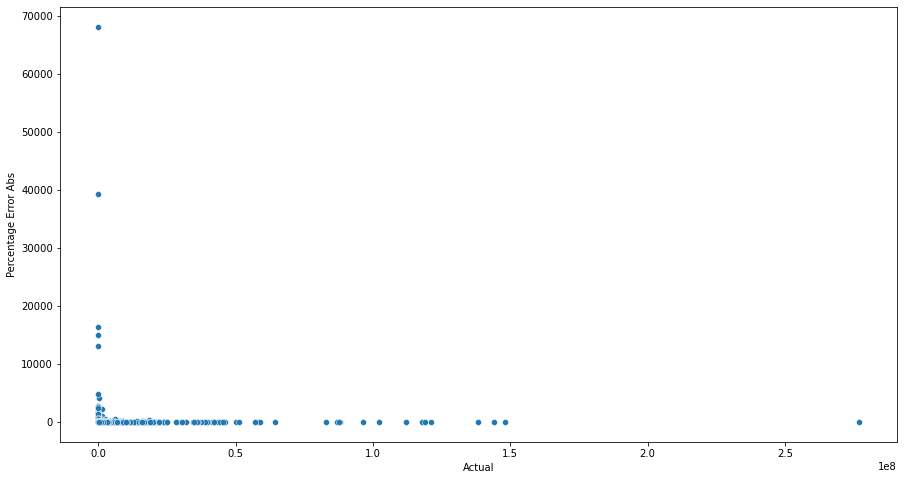

In [279]:
plt.figure(figsize=(15,8))
sns.scatterplot(x='Actual', y='Percentage Error Abs',data=forest_result)
plt.xlabel('Actual')
plt.ylabel('Percentage Error Abs')
plt.show()

From the graph above, it seems that the outliers of residual located in lower actual market value.

## General

### Excellent

In [327]:
len(forest_result[forest_result['Percentage Error Abs']<=10])

72848

In [329]:
len(forest_result[forest_result['Percentage Error Abs']<=10])/len(forest_result)*100

73.69326171183475

In [335]:
forest_result[forest_result['Percentage Error Abs']<=10][['market_value','total_area','total_livable_area','number_of_rooms']].describe()

,market_value,total_area,total_livable_area,number_of_rooms
count,7.284800e+04,72848.000000,72848.000000,72848.000000
mean,1.775035e+05,2218.124868,1524.399558,6.251064
std,7.089780e+05,6240.977793,5014.584699,2.104597
min,6.800000e+03,400.000000,0.000000,0.000000
25%,7.860000e+04,990.000000,1088.000000,6.000000
50%,1.301000e+05,1392.160000,1250.000000,6.000000
75%,2.054000e+05,2150.052500,1520.000000,6.000000
max,1.180000e+08,591327.000000,845230.000000,133.000000


Our model can make excellent predictions in 73.7% of total test data.

### Good

In [333]:
len(forest_result[(forest_result['Percentage Error Abs']>10)&(forest_result['Percentage Error Abs']<=20)])

11205

In [334]:
len(forest_result[(forest_result['Percentage Error Abs']>10)&(forest_result['Percentage Error Abs']<=20)])/len(forest_result)*100

11.335012594458437

In [337]:
forest_result[(forest_result['Percentage Error Abs']>10)&(forest_result['Percentage Error Abs']<=20)][['market_value','total_area','total_livable_area','number_of_rooms']].describe()

,market_value,total_area,total_livable_area,number_of_rooms
count,1.120500e+04,1.120500e+04,11205.000000,11205.000000
mean,3.408425e+05,3.673182e+03,2680.779384,6.675993
std,2.215274e+06,3.225033e+04,15416.072096,5.081366
min,6.800000e+03,4.011000e+02,0.000000,0.000000
25%,9.210000e+04,9.290000e+02,1140.000000,6.000000
50%,1.660000e+05,1.288620e+03,1446.000000,6.000000
75%,2.960000e+05,2.247000e+03,2030.000000,7.000000
max,1.384204e+08,2.578273e+06,797220.000000,133.000000


Our model can make good predictions in 11.3% of total test data.

### Bad

In [338]:
len(forest_result[(forest_result['Percentage Error Abs']>20)&(forest_result['Percentage Error Abs']<=25)])

3185

In [339]:
len(forest_result[(forest_result['Percentage Error Abs']>20)&(forest_result['Percentage Error Abs']<=25)])/len(forest_result)*100

3.2219558334092033

### Not accurate

In [340]:
len(forest_result[(forest_result['Percentage Error Abs']>25)])

11615

In [341]:
len(forest_result[(forest_result['Percentage Error Abs']>25)])/len(forest_result)*100

11.749769860297613

In [342]:
forest_result[(forest_result['Percentage Error Abs']>25)][['market_value','total_area','total_livable_area','number_of_rooms']].describe()

,market_value,total_area,total_livable_area,number_of_rooms
count,1.161500e+04,1.161500e+04,1.161500e+04,11615.000000
mean,4.946146e+05,6.785244e+03,4.698227e+03,6.999096
std,4.265088e+06,5.214561e+04,2.445387e+04,8.537313
min,6.800000e+03,4.000000e+02,0.000000e+00,0.000000
25%,5.760000e+04,9.280000e+02,1.140000e+03,6.000000
50%,1.133000e+05,1.306660e+03,1.512000e+03,6.000000
75%,2.414000e+05,2.280360e+03,2.332000e+03,7.000000
max,2.768920e+08,2.802944e+06,1.179072e+06,133.000000


## Extreme MAPE

In [289]:
forest_result[forest_result['Percentage Error Abs']>10000].sort_values('Percentage Error Abs')

,Actual,Prediction,Percentage Error,market_value,number_of_bedrooms,number_of_rooms,number_of_bathrooms,number_stories,overall_condition,property_age,sale_year,total_area,total_livable_area,category_code_description,central_air,fireplaces,new_zoning,other_building,parcel_shape,parking_spaces,street_designation,topography,unfinished,view_type,zip_code,building_code_description,distance_city_center,have_fireplaces,condominium,apartment,house,Percentage Error Abs
67628,16600.0,2188441.0,13083.379518,16600.0,3.0,6.0,1.0,2.0,5.0,100.0,2018.0,852500.00,1080.0,Single Family,0,0,Residential Multi Family,N,E,0,AVE,F,F,I,19134,ROW 2 STY MASONRY,Near City Center,0,0,0,1,13083.379518
25050,50000.0,7546931.0,14993.862000,50000.0,0.0,6.0,4.5,3.0,4.0,106.0,2017.0,74260.00,101520.0,Commercial,0,0,Residential Single Family,N,A,0,AVE,F,F,I,19144,SCHOOL 3 STY MASONRY,Far From City Center,0,0,0,0,14993.862000
50017,143500.0,23617352.0,16358.085017,143500.0,3.0,6.0,1.0,2.0,4.0,95.0,2009.0,1769.51,1890.0,Mixed Use,N,0,Mixed Used,N,E,0,AVE,F,F,I,19119,ROW W/OFF STR 2 STY MASON,Very Far From City Center NW,0,0,0,0,16358.085017
75627,98500.0,38836712.0,39328.134010,98500.0,3.0,6.0,1.0,2.0,4.0,95.0,2001.0,1770.00,1226.0,Single Family,N,0,Residential Single Family,N,E,0,ST,F,F,I,19119,ROW 2 STY MASONRY,Very Far From City Center NW,0,0,0,1,39328.134010
19929,86200.0,58790108.0,68101.981439,86200.0,3.0,6.0,1.0,2.0,4.0,95.0,2019.0,1770.00,1352.0,Single Family,N,0,Residential Single Family,N,E,0,ST,F,F,I,19119,ROW 2 STY MASONRY,Very Far From City Center NW,0,0,0,1,68101.981439


Data 67628 and 25050 have high total area and/or total livable area. Let's check properties with the same specifications.

In [301]:
forest_result[(forest_result['total_area']>850000)].sort_values('Percentage Error Abs', ascending=False)

,Actual,Prediction,Percentage Error,market_value,number_of_bedrooms,number_of_rooms,number_of_bathrooms,number_stories,overall_condition,property_age,sale_year,total_area,total_livable_area,category_code_description,central_air,fireplaces,new_zoning,other_building,parcel_shape,parking_spaces,street_designation,topography,unfinished,view_type,zip_code,building_code_description,distance_city_center,have_fireplaces,condominium,apartment,house,Percentage Error Abs
67628,16600.0,2188441.0,13083.379518,16600.0,3.0,6.0,1.0,2.0,5.0,100.0,2018.0,852500.00,1080.0,Single Family,0,0,Residential Multi Family,N,E,0,AVE,F,F,I,19134,ROW 2 STY MASONRY,Near City Center,0,0,0,1,13083.379518
36960,10748400.0,17992072.0,67.393026,10748400.0,0.0,6.0,1.0,1.0,4.0,47.0,1999.0,1086822.00,259200.0,Industrial,0,0,Industrial,N,E,0,BLV,A,F,I,19154,IND. LGHT MFG MASONRY,Very Far From City Center NE,0,0,0,0,67.393026
3176,13085300.0,4546356.0,-65.256005,13085300.0,0.0,0.0,0.0,0.0,4.0,153.0,2008.0,2802943.62,19059.0,Commercial,0,0,Residential Single Family,N,B,0,RD,F,F,0,19150,CEMETERY,Very Far From City Center NW,0,0,0,0,65.256005
1581,2370100.0,884059.0,-62.699506,2370100.0,0.0,0.0,0.0,1.0,4.0,140.0,1943.0,2178000.00,4800.0,Commercial,N,0,Residential Single Family,N,B,0,AVE,A,F,A,19135,CEMETERY,Far From City Center,0,0,0,0,62.699506
88393,10307300.0,5192314.0,-49.624887,10307300.0,0.0,6.0,4.5,3.0,4.0,60.0,1943.0,2131827.00,25477.0,Commercial,0,0,Residential Single Family,N,B,0,RD,F,F,I,19154,SCHOOL 3 STY MASONRY,Very Far From City Center NE,0,0,0,0,49.624887
14349,10679000.0,15769864.0,47.671730,10679000.0,35.5,101.5,66.0,3.0,4.0,70.0,1958.0,958320.00,200000.0,Multi Family,0,0,Residential Multi Family,N,A,0,BLV,F,F,I,19143,APTS 100+ UNITS MASONRY,Near City Center,0,0,1,0,47.671730
97128,45452100.0,26319660.0,-42.093633,45452100.0,0.0,7.0,1.0,2.0,4.0,70.0,2004.0,1001880.00,425128.0,Commercial,0,0,Residential Single Family,N,B,0,ST,F,F,I,19124,SCHOOL 2 STY MASONRY,Far From City Center,0,0,0,0,42.093633
13580,15742500.0,20372202.0,29.408938,15742500.0,0.0,4.0,1.0,1.0,3.0,19.0,2017.0,1324488.85,300700.0,Industrial,0,0,Industrial,N,E,1,RD,F,F,I,19154,IND WAREHOUSE MASONRY,Very Far From City Center NE,0,0,0,0,29.408938
94938,2500000.0,3123229.0,24.929160,2500000.0,0.0,0.0,0.0,0.0,6.0,90.0,2007.0,911710.80,0.0,Vacant Land,0,0,Industrial,N,B,0,BLV,F,F,I,19148,VACANT LAND INDUST ACRE+,Adjacent City Center,0,0,0,0,24.929160
67393,11565800.0,13973673.0,20.818906,11565800.0,0.0,6.0,4.5,3.0,4.0,72.0,2019.0,1524600.00,88417.0,Commercial,0,0,Residential Single Family,Y,B,0,AVE,F,F,I,19136,SCHOOL 3 STY MASONRY,Very Far From City Center NE,0,0,0,0,20.818906


In [302]:
forest_result[(forest_result['total_area']>74000)&(forest_result['total_livable_area']>100000)].sort_values('Percentage Error Abs', ascending=False)

,Actual,Prediction,Percentage Error,market_value,number_of_bedrooms,number_of_rooms,number_of_bathrooms,number_stories,overall_condition,property_age,sale_year,total_area,total_livable_area,category_code_description,central_air,fireplaces,new_zoning,other_building,parcel_shape,parking_spaces,street_designation,topography,unfinished,view_type,zip_code,building_code_description,distance_city_center,have_fireplaces,condominium,apartment,house,Percentage Error Abs
25050,50000.0,7546931.0,14993.862000,50000.0,0.0,6.0,4.5,3.0,4.0,106.0,2017.0,74260.0,101520.0,Commercial,0,0,Residential Single Family,N,A,0,AVE,F,F,I,19144,SCHOOL 3 STY MASONRY,Far From City Center,0,0,0,0,14993.862000
45716,18606400.0,73381810.0,294.390156,18606400.0,35.5,101.5,66.0,17.0,1.0,2.0,2017.0,112742.0,363801.0,Multi Family,Y,0,Mixed Used,N,E,1,AVE,F,F,I,19123,APTS 100+ UNITS MASONRY,City Center,0,0,1,0,294.390156
30706,1935200.0,7543649.0,289.812371,1935200.0,68.0,133.0,65.0,3.0,3.0,23.0,1991.0,105000.0,107551.0,Multi Family,0,0,Industrial,N,E,0,AVE,F,F,I,19133,APTS 51-100 UNITS MASONRY,Near City Center,0,0,1,0,289.812371
80284,4167800.0,12690546.0,204.490283,4167800.0,0.0,4.0,1.0,1.0,4.0,55.0,2016.0,555870.0,309254.0,Industrial,0,0,Industrial,N,A,0,RD,F,F,I,19154,IND WAREHOUSE MASONRY,Very Far From City Center NE,0,0,0,0,204.490283
71207,8089200.0,21499257.0,165.777296,8089200.0,35.5,101.5,66.0,4.0,4.0,85.0,2003.0,235200.0,268565.0,Multi Family,0,0,Residential Multi Family,N,B,0,ST,F,F,I,19124,APTS 100+ UNITS MASONRY,Far From City Center,0,0,1,0,165.777296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97154,19854000.0,18685806.0,-5.883923,19854000.0,35.5,101.5,66.0,13.0,4.0,90.0,2015.0,95832.0,180075.0,Multi Family,0,0,Mixed Used,N,A,0,ST,F,F,I,19143,APTS 100+ UNITS MASONRY,Near City Center,0,0,1,0,5.883923
79044,16429500.0,17152526.0,4.400779,16429500.0,35.5,101.5,66.0,2.0,4.0,50.0,2008.0,591327.0,189541.0,Multi Family,0,0,Residential Multi Family,N,C,0,AVE,F,F,0,19116,APTS 100+ UNITS MASONRY,Very Far From City Center NE,0,0,1,0,4.400779
15831,2724500.0,2631524.0,-3.412589,2724500.0,0.0,4.0,1.0,1.0,4.0,100.0,2010.0,233052.0,150988.0,Industrial,0,0,Mixed Used,N,B,0,ST,F,F,I,19137,IND WAREHOUSE MASONRY,Far From City Center,0,0,0,0,3.412589
8148,6922800.0,6783826.0,-2.007483,6922800.0,0.0,4.0,1.0,1.0,3.0,21.0,1998.0,459862.0,131987.0,Industrial,Y,0,Industrial,N,A,0,RD,F,F,I,19154,IND WAREHOUSE MASONRY,Very Far From City Center NE,0,0,0,0,2.007483


These two anomalies can't be detected in contextual outliers analysis since the data was covered by a lot of dots. (Check section 4.2.)

Let's check the other. Three properties with highest MAPE were located at zip code 19119.

In [291]:
forest_result[forest_result['zip_code']==19119]['market_value'].describe()

count    1.770000e+03
mean     2.806244e+05
std      2.948212e+05
min      3.870000e+04
25%      1.470000e+05
50%      2.197500e+05
75%      3.267000e+05
max      5.273100e+06
Name: market_value, dtype: float64

In [300]:
forest_result[(forest_result['number_of_rooms']==6)&
              ((forest_result['number_stories']==2)|(forest_result['number_stories']==3))&
              ((forest_result['overall_condition']==4)|(forest_result['overall_condition']==5))&
              (forest_result['sale_year']>2000)&
              (forest_result['property_age']>=95)&
              (forest_result['zip_code']==19119)].sort_values('Percentage Error Abs', ascending=False)

,Actual,Prediction,Percentage Error,market_value,number_of_bedrooms,number_of_rooms,number_of_bathrooms,number_stories,overall_condition,property_age,sale_year,total_area,total_livable_area,category_code_description,central_air,fireplaces,new_zoning,other_building,parcel_shape,parking_spaces,street_designation,topography,unfinished,view_type,zip_code,building_code_description,distance_city_center,have_fireplaces,condominium,apartment,house,Percentage Error Abs
19929,86200.0,58790108.0,68101.981439,86200.0,3.0,6.0,1.0,2.0,4.0,95.0,2019.0,1770.00,1352.0,Single Family,N,0,Residential Single Family,N,E,0,ST,F,F,I,19119,ROW 2 STY MASONRY,Very Far From City Center NW,0,0,0,1,68101.981439
75627,98500.0,38836712.0,39328.134010,98500.0,3.0,6.0,1.0,2.0,4.0,95.0,2001.0,1770.00,1226.0,Single Family,N,0,Residential Single Family,N,E,0,ST,F,F,I,19119,ROW 2 STY MASONRY,Very Far From City Center NW,0,0,0,1,39328.134010
50017,143500.0,23617352.0,16358.085017,143500.0,3.0,6.0,1.0,2.0,4.0,95.0,2009.0,1769.51,1890.0,Mixed Use,N,0,Mixed Used,N,E,0,AVE,F,F,I,19119,ROW W/OFF STR 2 STY MASON,Very Far From City Center NW,0,0,0,0,16358.085017
85948,53100.0,102043.0,92.171375,53100.0,3.0,6.0,1.0,3.0,5.0,95.0,2019.0,1557.00,926.0,Single Family,N,0,Residential Single Family,N,A,0,ST,F,F,I,19119,SEMI/DET 2.5 STY FRAME,Very Far From City Center NW,0,0,0,1,92.171375
7821,75000.0,142726.0,90.301333,75000.0,3.0,6.0,1.0,2.0,5.0,95.0,2017.0,2200.68,1440.0,Single Family,N,0,Residential Single Family,N,E,0,AVE,F,F,I,19119,SEMI/DET 2 STY MASONRY,Very Far From City Center NW,0,0,0,1,90.301333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60442,114600.0,114600.0,0.000000,114600.0,3.0,6.0,1.0,2.0,4.0,95.0,2005.0,1850.00,1240.0,Single Family,N,0,Residential Single Family,N,E,1,ST,F,F,I,19119,ROW B/GAR 2 STY MASONRY,Very Far From City Center NW,0,0,0,1,0.000000
11935,107600.0,107600.0,0.000000,107600.0,3.0,6.0,1.0,2.0,4.0,95.0,2011.0,1300.35,1164.0,Single Family,N,0,Residential Single Family,N,E,1,ST,F,F,I,19119,ROW B/GAR 2 STY MASONRY,Very Far From City Center NW,0,0,0,1,0.000000
62672,131200.0,131200.0,0.000000,131200.0,3.0,6.0,1.0,2.0,4.0,100.0,2014.0,930.56,1344.0,Single Family,N,0,Residential Multi Family,N,E,0,ST,F,F,I,19119,ROW 2 STY MASONRY,Very Far From City Center NW,0,0,0,1,0.000000
30598,213100.0,213100.0,0.000000,213100.0,3.0,6.0,1.0,2.0,4.0,95.0,2005.0,1650.00,1158.0,Single Family,N,0,Residential Single Family,N,E,1,RD,F,F,I,19119,ROW B/GAR 2 STY MAS+OTHER,Very Far From City Center NW,0,0,0,1,0.000000


We can't locate which features that can describe why the prediction value were so high since the data were subjectively comparable.

## Extreme Market Value

In [309]:
forest_result[forest_result['market_value']>0.5*1e8].sort_values('Percentage Error Abs',ascending=False)

,Actual,Prediction,Percentage Error,market_value,number_of_bedrooms,number_of_rooms,number_of_bathrooms,number_stories,overall_condition,property_age,sale_year,total_area,total_livable_area,category_code_description,central_air,fireplaces,new_zoning,other_building,parcel_shape,parking_spaces,street_designation,topography,unfinished,view_type,zip_code,building_code_description,distance_city_center,have_fireplaces,condominium,apartment,house,Percentage Error Abs
16668,102099800.0,37329241.0,-63.438478,102099800.0,0.0,4.0,1.0,5.0,4.0,11.0,2009.0,271467.00,259691.0,Commercial,0,0,Special Purpose Institution,N,B,0,ST,F,F,0,19104,SCHOOL 5 STY MASONRY,Adjacent City Center,0,0,0,0,63.438478
24926,58351700.0,25092462.0,-56.997890,58351700.0,35.5,101.5,66.0,5.0,1.0,11.0,2008.0,85438.00,217524.0,Multi Family,0,0,Residential Single Family,N,A,1,ST,F,F,I,19147,APTS 100+ UNITS MASONRY,City Center,0,0,1,0,56.997890
53712,121200000.0,52269030.0,-56.873738,121200000.0,35.5,101.5,66.0,9.0,1.0,2.0,2017.0,146803.80,458809.0,Multi Family,0,0,Mixed Used,N,E,1,ST,F,F,I,19146,APTS 100+ UNITS MASONRY,City Center,0,0,1,0,56.873738
65886,51137300.0,24727353.0,-51.645173,51137300.0,5.0,71.0,66.0,12.0,2.0,93.0,2017.0,37478.00,196587.0,Multi Family,Y,0,Mixed Used,N,B,1,ST,F,F,I,19146,APTS 100+ UNITS MASONRY,City Center,0,0,1,0,51.645173
27506,58919400.0,29548360.0,-49.849523,58919400.0,35.5,101.5,66.0,19.0,4.0,40.0,1964.0,30970.00,245943.0,Multi Family,0,0,Residential Multi Family,N,A,0,ST,F,F,I,19147,APTS 100+ UNITS MASONRY,City Center,0,0,1,0,49.849523
91391,147990400.0,86650101.0,-41.448837,147990400.0,0.0,4.0,1.0,11.0,2.0,91.0,2016.0,80658.00,600523.0,Commercial,0,0,Mixed Used,N,A,0,ST,F,F,I,19103,OFF BLD COM NO GAR MASON,City Center,0,0,0,0,41.448837
88563,119106200.0,70619886.0,-40.708472,119106200.0,35.5,101.5,66.0,9.0,1.0,7.0,2012.0,40497.60,310676.0,Multi Family,Y,0,Mixed Used,N,A,1,ST,F,F,I,19130,APTS 100+ UNITS MASONRY,City Center,0,0,1,0,40.708472
21590,88143900.0,55270626.0,-37.295007,88143900.0,35.5,101.5,66.0,12.0,2.0,69.0,2011.0,646604.64,520280.0,Multi Family,0,0,Residential Multi Family,N,B,0,ST,F,F,0,19144,APTS 100+ UNITS MASONRY,Far From City Center,0,0,1,0,37.295007
69781,276892000.0,175055056.0,-36.778579,276892000.0,35.5,101.5,66.0,18.0,2.0,61.0,1996.0,387684.00,1179072.0,Multi Family,0,0,Residential Multi Family,N,A,0,PL,F,F,I,19130,APTS 100+ UNITS MASONRY,City Center,0,0,1,0,36.778579
10952,96253900.0,125531580.0,30.417136,96253900.0,0.0,4.0,1.0,25.0,4.0,93.0,2008.0,35808.00,760200.0,Commercial,Y,0,Mixed Used,N,E,1,ST,F,F,I,19109,OFF BLD COM NO GAR MASON,Other,0,0,0,0,30.417136


In [310]:
len(forest_result[forest_result['market_value']>0.5*1e8])

20

Our model can only predict 8 of 20 properties with market value more than 0.5 x 1e8. Thus, when implementing this model to new data, we need to cautiously inspect the result of highly valued properties.

## MAPE more than 100 and less than 10000

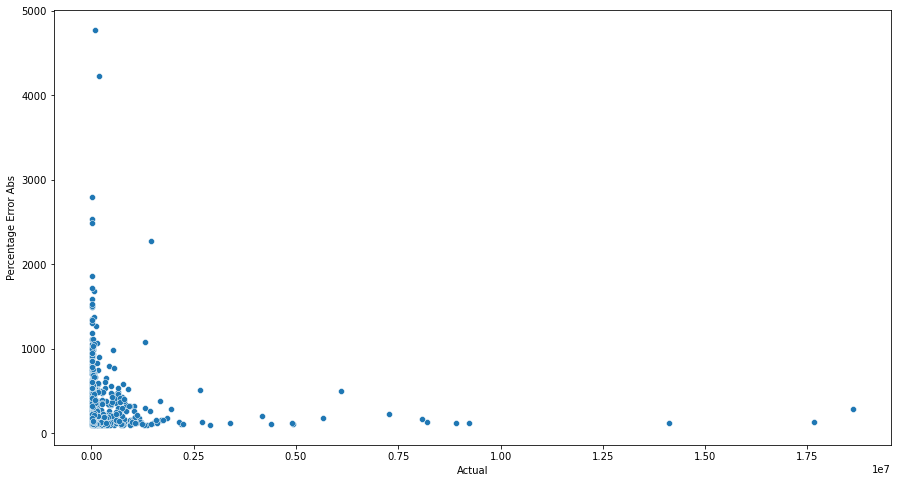

In [354]:
for_plot = forest_result[(forest_result['Percentage Error Abs']<=10000)&(forest_result['Percentage Error Abs']>100)]

plt.figure(figsize=(15,8))
sns.scatterplot(x='Actual', y='Percentage Error Abs',data=for_plot)
plt.xlabel('Actual')
plt.ylabel('Percentage Error Abs')
plt.show()

The extreme error in prediction didn't caused by Q3 outlier in market value, but hidden anomalies in the data with normal range of market value. To improve the model, we need to find the hidden anomalies.

In [352]:
len(for_plot[for_plot['Percentage Error Abs']>100])

1702

In [350]:
for_plot[for_plot['Percentage Error Abs']>100]['market_value'].describe()

count    1.702000e+03
mean     2.029327e+05
std      9.213423e+05
min      6.800000e+03
25%      2.602500e+04
50%      5.245000e+04
75%      1.032750e+05
max      1.860640e+07
Name: market_value, dtype: float64

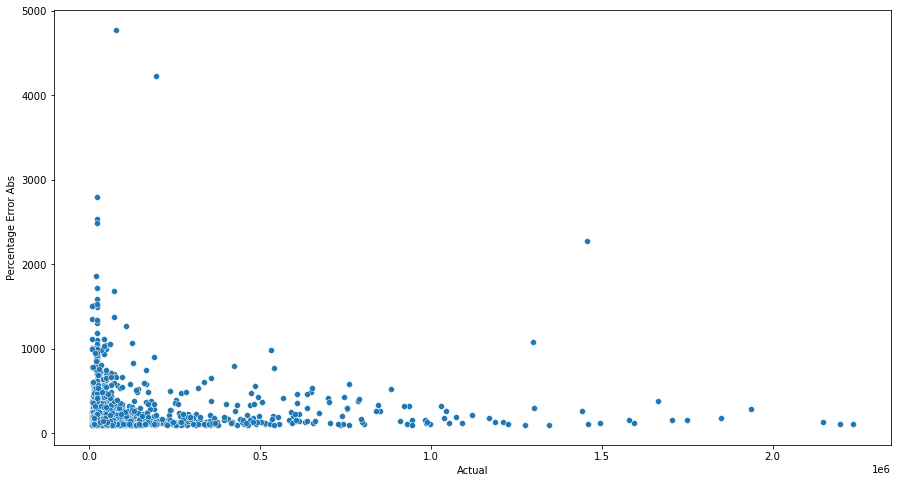

In [356]:
for_plot = for_plot[for_plot['Actual']<0.25*1e7]

plt.figure(figsize=(15,8))
sns.scatterplot(x='Actual', y='Percentage Error Abs',data=for_plot)
plt.xlabel('Actual')
plt.ylabel('Percentage Error Abs')
plt.show()

In [357]:
len(for_plot)

1684

## MAPE more than 25 and less than 100

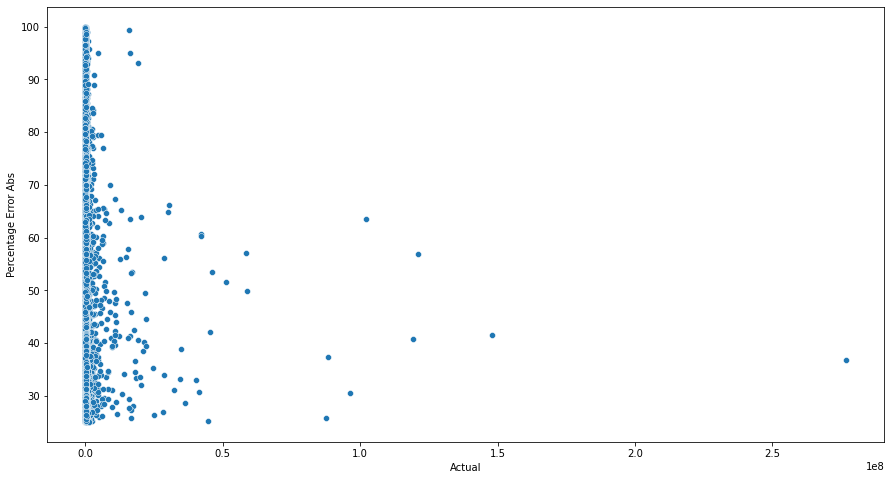

In [358]:
for_plot = forest_result[(forest_result['Percentage Error Abs']<=100)&(forest_result['Percentage Error Abs']>25)]

plt.figure(figsize=(15,8))
sns.scatterplot(x='Actual', y='Percentage Error Abs',data=for_plot)
plt.xlabel('Actual')
plt.ylabel('Percentage Error Abs')
plt.show()

Further showing that the anomalies are located in lower market value.

# Model Improvement based on Analysis

## Hypothesis 1

Maybe the presence of outliers affecting the regression coefficient somehow, thus resulting in more suitable algorithm to suit the outliers, leading to more error in lower actual market value. That may explain the extreme MAPE of some properties in section 9.1.2. Based on section 4.3, it seems that the outliers were located in market value more than 1.5 x 1e8.

In [368]:
df_predict[df_predict['market_value']>1.5*1e8]

,market_value,number_of_bedrooms,number_of_rooms,number_of_bathrooms,number_stories,overall_condition,property_age,sale_year,total_area,total_livable_area,category_code_description,central_air,fireplaces,new_zoning,other_building,parcel_shape,parking_spaces,street_designation,topography,unfinished,view_type,zip_code,building_code_description,distance_city_center,have_fireplaces,condominium,apartment,house
459511,165198800.0,0.0,1.0,1.0,1.0,4.0,57.0,1943.0,7741883.0,6290.0,Commercial,0,0,Residential Single Family,N,E,0,RD,F,F,I,19154,MISC FIRE/POLICE MASONRY,Very Far From City Center NE,0,0,0,0
468726,276892000.0,35.5,101.5,66.0,18.0,2.0,61.0,1996.0,387684.0,1179072.0,Multi Family,0,0,Residential Multi Family,N,A,0,PL,F,F,I,19130,APTS 100+ UNITS MASONRY,City Center,0,0,1,0
469182,200287300.0,35.5,101.5,66.0,19.0,2.0,59.0,1995.0,38808.0,738207.0,Multi Family,0,0,Mixed Used,N,E,0,BLV,F,F,I,19103,APTS 100+ UNITS MASONRY,City Center,0,0,1,0
481254,307363100.0,0.0,6.0,1.0,2.0,1.0,10.0,2014.0,1206908.0,880949.0,Commercial,0,0,Special Purpose Entertainment,N,B,1,AVE,C,F,I,19125,AMUSE HALL MASONRY,Adjacent City Center,0,0,0,0


The outliers only consist of 4 data. If dropping these very few data really affecting the model performance, it will prove our hypothesis above.

In [370]:
df2 = df_predict[df_predict['market_value']<=1.5*1e8]
df2.head()

,market_value,number_of_bedrooms,number_of_rooms,number_of_bathrooms,number_stories,overall_condition,property_age,sale_year,total_area,total_livable_area,category_code_description,central_air,fireplaces,new_zoning,other_building,parcel_shape,parking_spaces,street_designation,topography,unfinished,view_type,zip_code,building_code_description,distance_city_center,have_fireplaces,condominium,apartment,house
0,186800.0,4.0,7.0,2.0,3.0,5.0,100.0,1951.0,779.0,1650.0,Single Family,N,0,Residential Single Family,N,E,1,ST,F,F,I,19147,ROW W/GAR 3 STY MASONRY,City Center,0,0,0,1
1,341600.0,3.0,4.0,1.0,3.0,2.0,100.0,2017.0,779.1,1203.0,Single Family,Y,0,Residential Single Family,N,E,0,ST,F,F,I,19147,ROW 3 STY MASONRY,City Center,0,0,0,1
2,226200.0,4.0,5.0,1.0,2.0,4.0,100.0,1975.0,725.2,1482.0,Single Family,N,0,Residential Single Family,N,E,0,ST,F,F,I,19147,ROW 3 STY MASONRY,City Center,0,0,0,1
3,241500.0,4.0,8.0,2.0,2.0,4.0,100.0,2012.0,1433.0,2049.0,Single Family,Y,0,Residential Single Family,N,E,0,ST,F,F,I,19147,ROW 3 STY MASONRY,City Center,0,0,0,1
4,237000.0,4.0,6.0,2.0,3.0,4.0,100.0,2017.0,1500.0,1155.0,Single Family,N,0,Residential Single Family,N,E,0,ST,F,F,I,19147,ROW 3 STY MASONRY,City Center,0,0,0,1


### Data Splitting

In [371]:
y=df2['market_value']
x=df2.drop(columns=['market_value','building_code_description','fireplaces'])

In [372]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=2020)

### Cross-validation

In [373]:
models=[linreg_pipe,forest_pipe,xgb_pipe]
score=[]
mean_score=[]
std_score=[]

for i in models:
    model_cv=cross_val_score(i,x_train,y_train,scoring='neg_mean_absolute_percentage_error', cv=5, n_jobs=-1)
    score.append(model_cv)
    mean_score.append(model_cv.mean())
    std_score.append(model_cv.std())

pd.DataFrame({
    'model': ['LinReg','Forest','XGB'],
    'mean': mean_score,
    'std': std_score
})

,model,mean,std
0,LinReg,-0.992929,0.024819
1,Forest,-0.134896,0.004911
2,XGB,-0.291143,0.006251


### Performance

In [374]:
forest_pipe.fit(x_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['central_air',
                                                   'other_building',
                                                   'unfinished']),
                                                 ('binary', BinaryEncoder(),
                                                  ['category_code_description',
                                                   'distance_city_center',
                                                   'new_zoning', 'parcel_shape',
                                                   'parking_spaces',
                                                   'street_designation',
                                                   'topography', 'view_type',
                               

In [375]:
y_pred_forest=forest_pipe.predict(x_test)

In [376]:
forest_result=pd.DataFrame({'Actual':y_test, 'Prediction': y_pred_forest})
forest_result

,Actual,Prediction
236883,31300.0,31300.000000
337931,121500.0,122263.000000
189832,72400.0,72488.583333
276016,35100.0,35100.000000
302302,149300.0,149300.000000
...,...,...
392997,317200.0,317037.000000
105636,165100.0,165100.000000
180893,41900.0,41702.000000
311631,85600.0,85731.000000


In [377]:
print("MAPE SCORE: ",mean_absolute_percentage_error(y_test,y_pred_forest))
print("MAE SCORE: ",mean_absolute_error(y_test,y_pred_forest))
print("MSE SCORE: ",mean_squared_error(y_test,y_pred_forest))
print("RMSE SCORE: ",np.sqrt(mean_squared_error(y_test,y_pred_forest)))
print ("R2 SCORE: ", r2_score(y_test,y_pred_forest))

MAPE SCORE:  0.14151571491137907
MAE SCORE:  44340.26409721992
MSE SCORE:  519977844555.74615
RMSE SCORE:  721094.8928925694
R2 SCORE:  0.7776778115759162


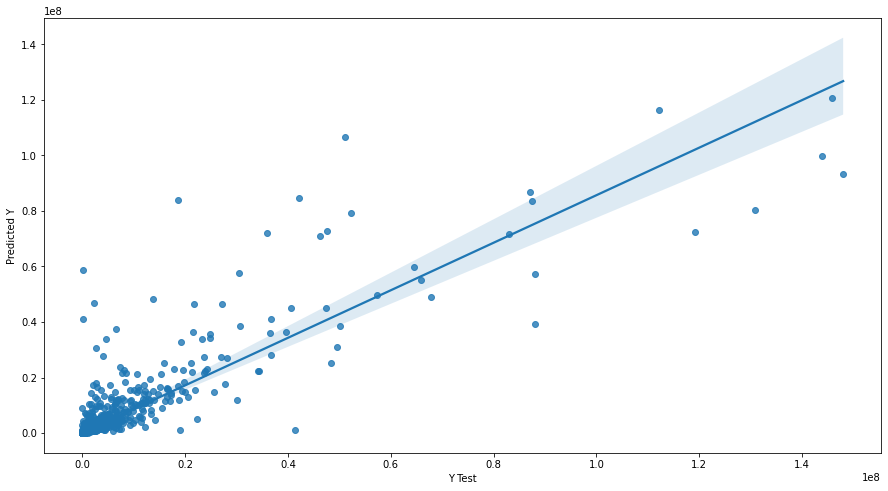

In [378]:
plt.figure(figsize=(15,8))
sns.regplot(x=y_test, y=y_pred_forest,fit_reg=True)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

No, removing market value more than 1.5 x 1e8 was reducing the model performance.

## Hypothesis 2

How about trimming low market value data? We didn't crosscheck the lower value of total livable area, yet.

(array([6.2000e+01, 2.5000e+01, 8.6000e+01, 1.5600e+02, 2.1000e+02,
        4.0400e+02, 2.8760e+03, 1.0332e+04, 1.8262e+04, 3.6929e+04]),
 array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000]),
 <BarContainer object of 10 artists>)

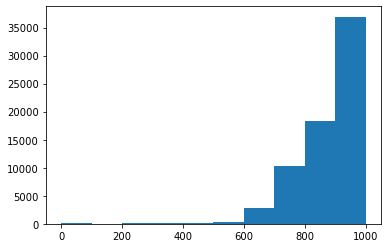

In [379]:
plt.hist(df_predict['total_livable_area'],bins=[0,100,200,300,400,500,600,700,800,900,1000])

In [380]:
index=df_predict[df_predict['total_livable_area']<600].index
df3=df_predict.drop(index)

### Data Splitting

In [381]:
y=df3['market_value']
x=df3.drop(columns=['market_value','building_code_description','fireplaces'])

In [382]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=2020)

### Performance

In [383]:
forest_pipe.fit(x_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['central_air',
                                                   'other_building',
                                                   'unfinished']),
                                                 ('binary', BinaryEncoder(),
                                                  ['category_code_description',
                                                   'distance_city_center',
                                                   'new_zoning', 'parcel_shape',
                                                   'parking_spaces',
                                                   'street_designation',
                                                   'topography', 'view_type',
                               

In [384]:
y_pred_forest=forest_pipe.predict(x_test)

In [385]:
forest_result=pd.DataFrame({'Actual':y_test, 'Prediction': y_pred_forest})
forest_result

,Actual,Prediction
267381,61000.0,62352.0
317385,101300.0,100398.0
187115,102000.0,108996.0
236144,9400.0,11051.0
245758,339600.0,255774.0
...,...,...
195130,160600.0,168415.0
317708,147400.0,135411.0
330539,59500.0,63640.0
352953,96600.0,88882.0


In [386]:
print("MAPE SCORE: ",mean_absolute_percentage_error(y_test,y_pred_forest))
print("MAE SCORE: ",mean_absolute_error(y_test,y_pred_forest))
print("MSE SCORE: ",mean_squared_error(y_test,y_pred_forest))
print("RMSE SCORE: ",np.sqrt(mean_squared_error(y_test,y_pred_forest)))
print ("R2 SCORE: ", r2_score(y_test,y_pred_forest))

MAPE SCORE:  0.12810461143600535
MAE SCORE:  42801.058053641835
MSE SCORE:  590637932627.6338
RMSE SCORE:  768529.7213690787
R2 SCORE:  0.787717469056796


Dropping several low market value observation really improves the model.

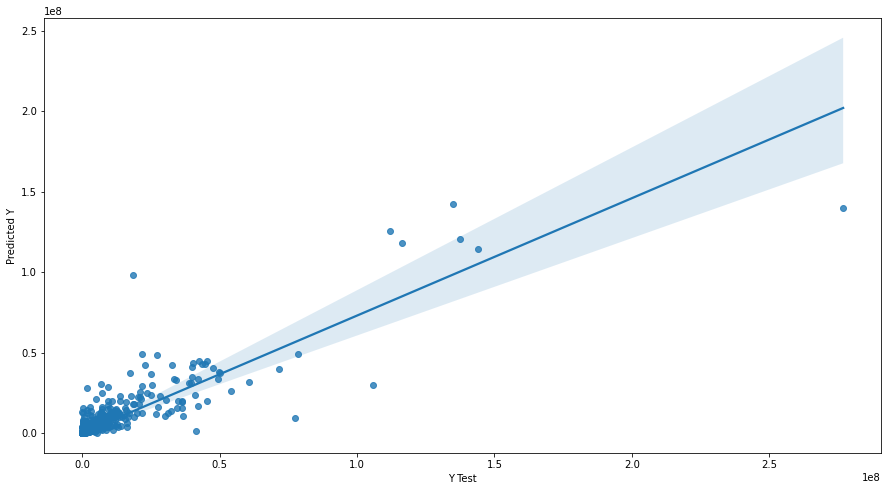

In [387]:
plt.figure(figsize=(15,8))
sns.regplot(x=y_test, y=y_pred_forest,fit_reg=True)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

### Residual Plot

In [389]:
forest_result['Percentage Error']=(forest_result['Prediction']-forest_result['Actual'])/forest_result['Actual']*100
forest_result['Percentage Error Abs']=abs(forest_result['Percentage Error'])

In [390]:
forest_result=forest_result.join(df3, how='inner').reset_index(drop=True)

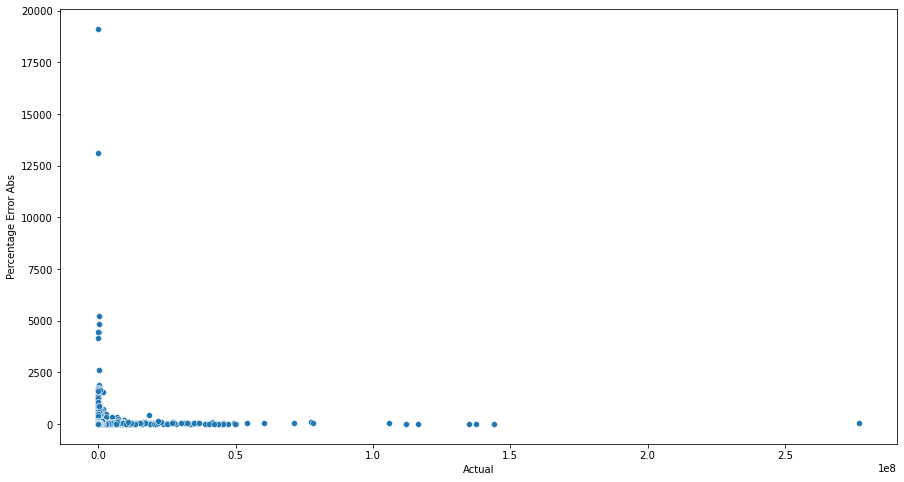

In [391]:
plt.figure(figsize=(15,8))
sns.scatterplot(x='Actual', y='Percentage Error Abs',data=forest_result)
plt.xlabel('Actual')
plt.ylabel('Percentage Error Abs')
plt.show()

In [413]:
len(forest_result[forest_result['Percentage Error Abs']>20])/len(forest_result)

0.14887039721070716

But the proportion of data with MAPE > 20% is still comparable to model with feature engineering only (section 6 and 9).

In [415]:
forest_result['Percentage Error Abs'].describe()

count    98663.000000
mean        12.819330
std        102.038808
min          0.000000
25%          0.258198
50%          2.093067
75%         10.593632
max      21819.280742
Name: Percentage Error Abs, dtype: float64

In [414]:
forest_result[forest_result['Percentage Error Abs']<=20]['Percentage Error Abs'].describe()

count    83975.000000
mean         3.625968
std          4.898277
min          0.000000
25%          0.162532
50%          1.216225
75%          5.370349
max         19.999682
Name: Percentage Error Abs, dtype: float64

# Recommendation

For excellent model with MAPE less than 10%, we need to clean the data further, especially in lower market value.